In [1]:
from __future__ import division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import time
import os

from ops import *
from utils import *

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
DATA_PATH = './img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=50 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=32*4 # Length of first tensor in generator

IMAGE_SIZE=32 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 2 # Number images in merged image
MERGE_Y = 2

In [3]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [4]:
def generator(z, is_training, g_bnorms):
    # Firstly let's reshape input vector into 3-d tensor. 
    
    z_ = linear(z, GENERATOR_DENSE_SIZE * 2*2, 'g_h0_lin')
    h_in = tf.reshape(z_, [-1, 2, 2, GENERATOR_DENSE_SIZE])
    
    g_bnorm_1 = g_bnorms[0](h_in, train=is_training)
    g_lrelu_1 = lrelu(g_bnorm_1,name="g_lrelu1")
    g_deconv_1 = deconv2d(g_lrelu_1,[BATCH_SIZE, 4, 4, 256],name="g_deconv1")
    
    g_bnorm_2 = g_bnorms[1](g_deconv_1, train=is_training)
    g_lrelu_2 = lrelu(g_bnorm_2,name="g_lrelu2")
    g_deconv_2 = deconv2d(g_lrelu_2,[BATCH_SIZE, 8, 8, 128],name="g_deconv2")
    
    g_bnorm_3 = g_bnorms[2](g_deconv_2, train=is_training)
    g_lrelu_3 = lrelu(g_bnorm_3,name="g_lrelu3")
    g_deconv_3 = deconv2d(g_lrelu_3,[BATCH_SIZE, 16, 16, 64],name="g_deconv3")
    
    g_bnorm_4 = g_bnorms[3](g_deconv_3, train=is_training)
    g_lrelu_4 = lrelu(g_bnorm_4,name="g_lrelu4")
    
    h_out = deconv2d(g_lrelu_4, [BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS],
            name='g_out')

    return tf.nn.tanh(h_out)

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to flatten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [5]:
def discriminator(image, is_training, d_bnorms):
    
    d_conv_1 = conv2d(image, 32, name='d_conv1')
    d_bnorm_1 = d_bnorms[0](d_conv_1, train=is_training)
    d_lrelu_1 = lrelu(d_bnorm_1, name='d_lrelu1')
    
    d_conv_2 = conv2d(d_lrelu_1, 64, name='d_conv2')
    d_bnorm_2 = d_bnorms[1](d_conv_2, train=is_training)
    d_lrelu_2 = lrelu(d_bnorm_2, name='d_lrelu2')
    
    d_conv_3 = conv2d(d_lrelu_2, 128, name='d_conv3')
    d_bnorm_3 = d_bnorms[2](d_conv_3, train=is_training)
    d_lrelu_3 = lrelu(d_bnorm_3, name='d_lrelu3')
    
    d_conv_4 = conv2d(d_lrelu_3, 256, name='d_conv4')
    d_bnorm_4 = d_bnorms[3](d_conv_4, train=is_training)
    d_lrelu_4 = lrelu(d_bnorm_4, name='d_lrelu4')
    
    d_lrelu_4_flatten = tf.contrib.layers.flatten(d_lrelu_4)
    
    linear_out = linear(d_lrelu_4_flatten, 1)
    
    return tf.nn.sigmoid(linear_out), linear_out

Now let's define generator and discriminator.

In [6]:
tf.reset_default_graph()
is_training = tf.placeholder(tf.bool, name='is_training')

with tf.variable_scope("G") as scope:
    z = tf.placeholder(tf.float32, [None, Z_DIM], name='z')
    g_bnorms = [batch_norm(name="g_bnorm1"), batch_norm(name="g_bnorm2"), batch_norm(name="g_bnorm3"), 
                batch_norm(name="g_bnorm4")]
    G = generator(z, is_training, g_bnorms)

with tf.variable_scope('D') as scope:
    images = tf.placeholder(tf.float32, shape=[None, IMAGE_SIZE, IMAGE_SIZE, N_CHANNELS])
    d_bnorms = [batch_norm(name="d_bnorm1"), batch_norm(name="d_bnorm2"), batch_norm(name="d_bnorm3"),
               batch_norm(name="d_bnorm4")]
    D_real, D_real_logits = discriminator(images, is_training, d_bnorms)
    scope.reuse_variables()
    D_fake, D_fake_logits = discriminator(G, is_training, d_bnorms)

/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [7]:
d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_real_logits, labels=tf.ones_like(D_real_logits)))

d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.zeros_like(D_fake_logits)))

d_loss = d_loss_real + d_loss_fake

g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_fake_logits, labels=tf.ones_like(D_fake_logits)))

Create optimizers. We use different optimizers for discriminator and generator, so we needed a separate prefix for the discriminator and generator variables (g_ for generator, d_ for disciminator).

In [8]:
tvars = tf.trainable_variables()
## All variables of discriminator
d_vars = [v for v in tvars if 'd_' in v.name]

## All variables of generator
g_vars = [v for v in tvars if 'g_' in v.name]

LEARNING_RATE = 0.0002 # Learning rate for adam optimizer
BETA = 0.5 # Beta paramater in adam optimizer

##Optimizers - ypu may use your favourite instead.
d_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(d_loss, var_list=d_vars)
g_optim = tf.train.AdamOptimizer(LEARNING_RATE, beta1=BETA) \
                  .minimize(g_loss, var_list=g_vars) 

Load data: Total no. of images = 202599. I load only the first 32768, otherwise each epoch was taking 12 hours!

In [12]:
data = glob(os.path.join(DATA_PATH, "*.jpg"))[:32768]
assert(len(data) > 0), "Length of training data should be more than zero"
print(len(data))

32768


Functions for training and evaluations.

In [13]:
def load(sess, load_dir):
    """load network's paramaters
    
    load_dir : path to load dir
    """
    saver = tf.train.Saver()
    ckpt = tf.train.get_checkpoint_state(load_dir)
    if ckpt and ckpt.model_checkpoint_path:
            saver.restore(sess, ckpt.model_checkpoint_path)

I have very limited computational resources available to me (4GB RAM, no GPU, 1.8MHz CPU). So I am unable to do this task with 64x64 images. I am using 32x32 images instead. Significantly inferior results, but it is the best I can do. 

Images in downloaded dataset are of size 218x178, therefore need to be resized to 32x32.

In [14]:
from skimage.transform import resize

def get_resize_transform_image(image_path):
    return transform(resize(plt.imread(image_path),(IMAGE_SIZE,IMAGE_SIZE,N_CHANNELS),preserve_range=True, 
                            mode='reflect', anti_aliasing=True))

In [15]:
image_path = data[2]
c = plt.imread(image_path)
print(c.shape)
d = get_resize_transform_image(image_path)
print(d.shape)

(218, 178, 3)
(32, 32, 3)


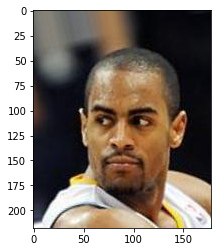

In [16]:
plt.imshow(c)

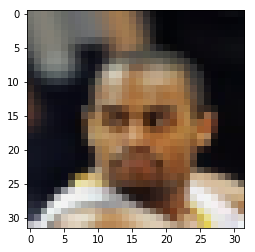

In [44]:
plt.imshow(inverse_transform(d))

## Training GAN (1 point + 2 for good results)

I tried using two different sets of architectures for the Generator and Disciminator. 
> Model 1: Shallower D and G. Larger kernel widths for the convolutional filters. Default initial noise vector.

> Model 2: Deeper D and G by one layer compared to Model 1. Smaller kernel widths. Smaller initial noise vector. 


Due to computational limitatations, training was very slow for both. 

In [45]:
def train(sess, load_dir=None, save_frequency=128, sample_frequency=64, sample_dir='sample_faces',
          save_dir='checkpoint', max_to_keep=1, model_name='dcgan.model',
          n_epochs=25, n_generator_update=2):
    """train gan
    Parameters
    -------------------------------------------
    load_dir : str, default = None
        path to the folder with parameters
    save_frequency: int, default = 100
        how often save parameters []
    sample_frequency: int, default = None (not sample)
        how often sample faces
    sample_dir: str, default = samples
        directory for sampled images
    save_dir: str, default = 'checkpoint'
        path where to save parameters
    max_to_keep: int, default = 1
        how many last checkpoints to store
    model_name: str, default='dcgan.model'
        name of model
    n_epochs: int, default = 25 
        number epochs to train
    n_generator_update: int, default = 2
        how many times run generator updates per one discriminator update
    -------------------------------------------
    """
    
    if save_frequency is not None:
        saver = tf.train.Saver(max_to_keep=max_to_keep)
        
    if load_dir is not None:
        print("Reading checkpoints...")
        load(sess, load_dir)
        print("Loaded checkpoints")
    else:
        try:
            tf.global_variables_initializer().run()
        except:
            tf.initialize_all_variables().run()

    counter=1
    start_time = time.time()
    
    for epoch in range(n_epochs):
        batch_idxs = min(len(data), np.inf) // BATCH_SIZE
        for idx in range(0, batch_idxs):
            batch_files = data[idx*BATCH_SIZE:(idx+1)*BATCH_SIZE]
            batch = [get_resize_transform_image(batch_file) for batch_file in batch_files]
            batch_images = np.array(batch).astype(np.float32)
            batch_z = np.random.uniform(-1, 1, [BATCH_SIZE, Z_DIM]).astype(np.float32)

            # Update D network
            sess.run(d_optim, feed_dict={images: batch_images, z: batch_z,is_training: True})

            # Update G network
            for _ in range(n_generator_update):
                sess.run(g_optim,
                    feed_dict={z: batch_z, is_training: True})

            errD_fake = d_loss_fake.eval({z: batch_z, is_training: False})
            errD_real = d_loss_real.eval({images: batch_images, is_training: False})
            errG = g_loss.eval({z: batch_z, is_training: False})

            counter += 1
            print("Epoch: [{:2d}] [{:4d}/{:4d}] time: {:4.4f}, d_loss: {:.8f}, g_loss: {:.8f}".format(
                epoch, idx, batch_idxs, time.time() - start_time, errD_fake+errD_real, errG))

            if np.mod(counter, save_frequency) == 1:
                print("Saved model")
                saver.save(sess, 
                           os.path.join(save_dir, model_name))

            if np.mod(counter, sample_frequency) == 1:
                samples = sess.run(G, feed_dict={z: batch_z, is_training: False} )
                save_images(samples[:MERGE_X*MERGE_Y], [MERGE_X, MERGE_Y],
                            os.path.join(sample_dir, 'train_{:02d}_{:04d}.png'.format(epoch, idx)))
                print("Sample")

Model 1 training: Trained for almost 20 hours, almost 12 epochs complete. 

Stopped training due to worsening sample appearances. They can be seen in sample_faces_old. 

In [39]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint')

Epoch 0
Epoch: [ 0] [   0/ 512] time: 14.6911, d_loss: 1.37506473, g_loss: 0.67439830
Epoch: [ 0] [   1/ 512] time: 24.7197, d_loss: 1.36561334, g_loss: 0.66351902
Epoch: [ 0] [   2/ 512] time: 34.6589, d_loss: 1.34521079, g_loss: 0.67386079
Epoch: [ 0] [   3/ 512] time: 44.7012, d_loss: 1.32295978, g_loss: 0.69289839
Epoch: [ 0] [   4/ 512] time: 58.6578, d_loss: 1.29845500, g_loss: 0.72093511
Epoch: [ 0] [   5/ 512] time: 68.9861, d_loss: 1.25766218, g_loss: 0.75242978
Epoch: [ 0] [   6/ 512] time: 79.5000, d_loss: 1.25071716, g_loss: 0.72493947
Epoch: [ 0] [   7/ 512] time: 93.6259, d_loss: 1.22932327, g_loss: 0.68310571
Epoch: [ 0] [   8/ 512] time: 103.8607, d_loss: 1.27912903, g_loss: 0.63886547
Epoch: [ 0] [   9/ 512] time: 114.4351, d_loss: 1.44162726, g_loss: 0.58181602
Epoch: [ 0] [  10/ 512] time: 124.8137, d_loss: 1.74292350, g_loss: 0.44492364
Epoch: [ 0] [  11/ 512] time: 139.0159, d_loss: 2.01222706, g_loss: 0.35678089
Epoch: [ 0] [  12/ 512] time: 149.1509, d_loss: 2.15

Epoch: [ 0] [ 104/ 512] time: 1271.9229, d_loss: 2.65237117, g_loss: 0.88667142
Epoch: [ 0] [ 105/ 512] time: 1284.8742, d_loss: 2.42181277, g_loss: 1.02972651
Epoch: [ 0] [ 106/ 512] time: 1297.5314, d_loss: 2.24428368, g_loss: 0.98336995
Epoch: [ 0] [ 107/ 512] time: 1308.8325, d_loss: 2.16681051, g_loss: 0.91950136
Epoch: [ 0] [ 108/ 512] time: 1321.7040, d_loss: 2.02907562, g_loss: 0.95797431
Epoch: [ 0] [ 109/ 512] time: 1334.4144, d_loss: 1.83620262, g_loss: 0.93527198
Epoch: [ 0] [ 110/ 512] time: 1346.1932, d_loss: 1.83160257, g_loss: 0.87482738
Epoch: [ 0] [ 111/ 512] time: 1360.1209, d_loss: 2.24768257, g_loss: 0.71247107
Epoch: [ 0] [ 112/ 512] time: 1371.1456, d_loss: 2.02162504, g_loss: 0.69330549
Epoch: [ 0] [ 113/ 512] time: 1384.3664, d_loss: 2.26593399, g_loss: 0.62420440
Epoch: [ 0] [ 114/ 512] time: 1396.5153, d_loss: 2.32803059, g_loss: 0.57511985
Epoch: [ 0] [ 115/ 512] time: 1407.4929, d_loss: 2.16493177, g_loss: 0.60177541
Epoch: [ 0] [ 116/ 512] time: 1420.2579,

Epoch: [ 0] [ 206/ 512] time: 2541.1084, d_loss: 1.79560876, g_loss: 0.60591495
Epoch: [ 0] [ 207/ 512] time: 2554.0166, d_loss: 1.99883091, g_loss: 0.56374955
Epoch: [ 0] [ 208/ 512] time: 2566.4658, d_loss: 1.80467534, g_loss: 0.54707855
Epoch: [ 0] [ 209/ 512] time: 2577.4285, d_loss: 1.77184999, g_loss: 0.54232657
Epoch: [ 0] [ 210/ 512] time: 2591.9941, d_loss: 1.77945805, g_loss: 0.54691344
Epoch: [ 0] [ 211/ 512] time: 2602.7692, d_loss: 1.86351788, g_loss: 0.50042057
Epoch: [ 0] [ 212/ 512] time: 2613.6694, d_loss: 1.73206544, g_loss: 0.54009438
Epoch: [ 0] [ 213/ 512] time: 2624.8431, d_loss: 1.80529511, g_loss: 0.50042963
Epoch: [ 0] [ 214/ 512] time: 2639.0664, d_loss: 1.88864446, g_loss: 0.50999159
Epoch: [ 0] [ 215/ 512] time: 2649.9804, d_loss: 1.81114578, g_loss: 0.53444284
Epoch: [ 0] [ 216/ 512] time: 2661.7221, d_loss: 1.86708856, g_loss: 0.52907425
Epoch: [ 0] [ 217/ 512] time: 2675.6014, d_loss: 1.87866509, g_loss: 0.52100575
Epoch: [ 0] [ 218/ 512] time: 2686.4437,

Epoch: [ 0] [ 309/ 512] time: 3810.8097, d_loss: 1.53871500, g_loss: 0.63330257
Epoch: [ 0] [ 310/ 512] time: 3821.6651, d_loss: 1.69046569, g_loss: 0.62507254
Epoch: [ 0] [ 311/ 512] time: 3832.6088, d_loss: 1.63826346, g_loss: 0.59906387
Epoch: [ 0] [ 312/ 512] time: 3843.6343, d_loss: 1.70207262, g_loss: 0.58444428
Epoch: [ 0] [ 313/ 512] time: 3856.6868, d_loss: 1.65843952, g_loss: 0.60550582
Epoch: [ 0] [ 314/ 512] time: 3869.1472, d_loss: 1.72531772, g_loss: 0.58762574
Epoch: [ 0] [ 315/ 512] time: 3880.5440, d_loss: 1.71749353, g_loss: 0.60092312
Epoch: [ 0] [ 316/ 512] time: 3894.3521, d_loss: 1.70519817, g_loss: 0.60570502
Epoch: [ 0] [ 317/ 512] time: 3905.2107, d_loss: 1.75358045, g_loss: 0.59927279
Epoch: [ 0] [ 318/ 512] time: 3917.7718, d_loss: 1.66149473, g_loss: 0.62811166
Epoch: [ 0] [ 319/ 512] time: 3930.4452, d_loss: 1.66260862, g_loss: 0.61724550
Saved model
Sample
Epoch: [ 0] [ 320/ 512] time: 3943.8846, d_loss: 1.63937140, g_loss: 0.64891028
Epoch: [ 0] [ 321/ 51

Epoch: [ 0] [ 411/ 512] time: 5064.4623, d_loss: 1.52033746, g_loss: 0.59734273
Epoch: [ 0] [ 412/ 512] time: 5083.5537, d_loss: 1.55703497, g_loss: 0.54822510
Epoch: [ 0] [ 413/ 512] time: 5094.1736, d_loss: 1.58831763, g_loss: 0.54579234
Epoch: [ 0] [ 414/ 512] time: 5105.0594, d_loss: 1.64076293, g_loss: 0.55329287
Epoch: [ 0] [ 415/ 512] time: 5116.3409, d_loss: 1.65954626, g_loss: 0.53654724
Epoch: [ 0] [ 416/ 512] time: 5130.9541, d_loss: 1.62375689, g_loss: 0.53072524
Epoch: [ 0] [ 417/ 512] time: 5143.4465, d_loss: 1.75028074, g_loss: 0.51559526
Epoch: [ 0] [ 418/ 512] time: 5158.4069, d_loss: 1.68811321, g_loss: 0.53753215
Epoch: [ 0] [ 419/ 512] time: 5170.6010, d_loss: 1.69905460, g_loss: 0.55042660
Epoch: [ 0] [ 420/ 512] time: 5182.7518, d_loss: 1.69382632, g_loss: 0.59127164
Epoch: [ 0] [ 421/ 512] time: 5200.1427, d_loss: 1.68365538, g_loss: 0.61470795
Epoch: [ 0] [ 422/ 512] time: 5214.8303, d_loss: 1.65642440, g_loss: 0.62610012
Epoch: [ 0] [ 423/ 512] time: 5231.1178,

Epoch: [ 1] [   1/ 512] time: 6374.2115, d_loss: 1.55468905, g_loss: 0.60326302
Epoch: [ 1] [   2/ 512] time: 6392.8720, d_loss: 1.58777976, g_loss: 0.59794909
Epoch: [ 1] [   3/ 512] time: 6411.3224, d_loss: 1.54051208, g_loss: 0.59834230
Epoch: [ 1] [   4/ 512] time: 6429.7813, d_loss: 1.54232907, g_loss: 0.60773516
Epoch: [ 1] [   5/ 512] time: 6448.1675, d_loss: 1.55867231, g_loss: 0.59987330
Epoch: [ 1] [   6/ 512] time: 6466.6491, d_loss: 1.54721701, g_loss: 0.61581647
Epoch: [ 1] [   7/ 512] time: 6485.0685, d_loss: 1.53330421, g_loss: 0.62380999
Epoch: [ 1] [   8/ 512] time: 6503.8133, d_loss: 1.51150393, g_loss: 0.59126455
Epoch: [ 1] [   9/ 512] time: 6522.1877, d_loss: 1.54650331, g_loss: 0.59726596
Epoch: [ 1] [  10/ 512] time: 6540.6083, d_loss: 1.54914463, g_loss: 0.61372972
Epoch: [ 1] [  11/ 512] time: 6558.9926, d_loss: 1.53104281, g_loss: 0.61414945
Epoch: [ 1] [  12/ 512] time: 6577.4135, d_loss: 1.53837585, g_loss: 0.61054987
Epoch: [ 1] [  13/ 512] time: 6595.8057,

Epoch: [ 1] [ 104/ 512] time: 8238.0572, d_loss: 1.48472166, g_loss: 0.61023474
Epoch: [ 1] [ 105/ 512] time: 8248.0360, d_loss: 1.46426427, g_loss: 0.62727928
Epoch: [ 1] [ 106/ 512] time: 8258.1634, d_loss: 1.46746159, g_loss: 0.63594985
Epoch: [ 1] [ 107/ 512] time: 8268.3506, d_loss: 1.42758536, g_loss: 0.66356897
Epoch: [ 1] [ 108/ 512] time: 8278.5944, d_loss: 1.48489857, g_loss: 0.65878963
Epoch: [ 1] [ 109/ 512] time: 8288.8241, d_loss: 1.47466636, g_loss: 0.65604836
Epoch: [ 1] [ 110/ 512] time: 8299.3923, d_loss: 1.44073343, g_loss: 0.68393958
Epoch: [ 1] [ 111/ 512] time: 8313.2889, d_loss: 1.44103360, g_loss: 0.68804902
Epoch: [ 1] [ 112/ 512] time: 8326.3246, d_loss: 1.46189117, g_loss: 0.66421926
Epoch: [ 1] [ 113/ 512] time: 8336.5801, d_loss: 1.41838336, g_loss: 0.68099701
Epoch: [ 1] [ 114/ 512] time: 8346.7694, d_loss: 1.43660116, g_loss: 0.66718793
Epoch: [ 1] [ 115/ 512] time: 8357.1447, d_loss: 1.47263706, g_loss: 0.64711827
Epoch: [ 1] [ 116/ 512] time: 8369.7710,

Epoch: [ 1] [ 206/ 512] time: 9439.2780, d_loss: 1.48849392, g_loss: 0.65705413
Epoch: [ 1] [ 207/ 512] time: 9451.2900, d_loss: 1.50350904, g_loss: 0.64989889
Epoch: [ 1] [ 208/ 512] time: 9461.5542, d_loss: 1.46267903, g_loss: 0.67873514
Epoch: [ 1] [ 209/ 512] time: 9473.8319, d_loss: 1.43563592, g_loss: 0.70365638
Epoch: [ 1] [ 210/ 512] time: 9485.7487, d_loss: 1.42583466, g_loss: 0.71894723
Epoch: [ 1] [ 211/ 512] time: 9495.9936, d_loss: 1.41034675, g_loss: 0.72116750
Epoch: [ 1] [ 212/ 512] time: 9506.4727, d_loss: 1.41692388, g_loss: 0.71172768
Epoch: [ 1] [ 213/ 512] time: 9520.4383, d_loss: 1.39343011, g_loss: 0.71546650
Epoch: [ 1] [ 214/ 512] time: 9530.5921, d_loss: 1.41640532, g_loss: 0.70257938
Epoch: [ 1] [ 215/ 512] time: 9544.5844, d_loss: 1.44731116, g_loss: 0.66470993
Epoch: [ 1] [ 216/ 512] time: 9554.6742, d_loss: 1.49601305, g_loss: 0.62757540
Epoch: [ 1] [ 217/ 512] time: 9565.3277, d_loss: 1.51536191, g_loss: 0.61051881
Epoch: [ 1] [ 218/ 512] time: 9578.9391,

Epoch: [ 1] [ 308/ 512] time: 10670.7942, d_loss: 1.43159223, g_loss: 0.66445577
Epoch: [ 1] [ 309/ 512] time: 10681.5360, d_loss: 1.45831752, g_loss: 0.65199876
Epoch: [ 1] [ 310/ 512] time: 10695.1228, d_loss: 1.43264699, g_loss: 0.66271889
Epoch: [ 1] [ 311/ 512] time: 10706.1280, d_loss: 1.40949440, g_loss: 0.67589742
Epoch: [ 1] [ 312/ 512] time: 10719.5526, d_loss: 1.42603123, g_loss: 0.66945797
Epoch: [ 1] [ 313/ 512] time: 10730.1635, d_loss: 1.43088007, g_loss: 0.65871882
Epoch: [ 1] [ 314/ 512] time: 10743.6238, d_loss: 1.43619728, g_loss: 0.66547376
Epoch: [ 1] [ 315/ 512] time: 10753.8730, d_loss: 1.43396449, g_loss: 0.65873355
Epoch: [ 1] [ 316/ 512] time: 10765.8154, d_loss: 1.43356943, g_loss: 0.66383839
Epoch: [ 1] [ 317/ 512] time: 10778.2086, d_loss: 1.44612122, g_loss: 0.66457182
Epoch: [ 1] [ 318/ 512] time: 10789.0883, d_loss: 1.40185308, g_loss: 0.69978076
Epoch: [ 1] [ 319/ 512] time: 10802.5472, d_loss: 1.43133199, g_loss: 0.67802513
Saved model
Sample
Epoch: [ 

Epoch: [ 1] [ 409/ 512] time: 12043.7041, d_loss: 1.48972726, g_loss: 0.62192792
Epoch: [ 1] [ 410/ 512] time: 12062.1064, d_loss: 1.48134470, g_loss: 0.64394671
Epoch: [ 1] [ 411/ 512] time: 12080.5357, d_loss: 1.47616827, g_loss: 0.64145279
Epoch: [ 1] [ 412/ 512] time: 12098.9368, d_loss: 1.46277404, g_loss: 0.64566600
Epoch: [ 1] [ 413/ 512] time: 12117.3667, d_loss: 1.45236838, g_loss: 0.66787225
Epoch: [ 1] [ 414/ 512] time: 12135.8308, d_loss: 1.41903615, g_loss: 0.68816304
Epoch: [ 1] [ 415/ 512] time: 12154.4032, d_loss: 1.44627917, g_loss: 0.67909783
Epoch: [ 1] [ 416/ 512] time: 12172.8680, d_loss: 1.44845057, g_loss: 0.69321227
Epoch: [ 1] [ 417/ 512] time: 12191.2887, d_loss: 1.42063451, g_loss: 0.69594908
Epoch: [ 1] [ 418/ 512] time: 12209.7140, d_loss: 1.41272378, g_loss: 0.69320148
Epoch: [ 1] [ 419/ 512] time: 12228.1536, d_loss: 1.39191198, g_loss: 0.69602287
Epoch: [ 1] [ 420/ 512] time: 12246.5434, d_loss: 1.42553282, g_loss: 0.68567324
Epoch: [ 1] [ 421/ 512] time

Epoch: [ 1] [ 510/ 512] time: 13463.7876, d_loss: 1.44996047, g_loss: 0.65447140
Epoch: [ 1] [ 511/ 512] time: 13477.1343, d_loss: 1.47586930, g_loss: 0.66111279
Saved model
Sample
Epoch 2
Epoch: [ 2] [   0/ 512] time: 13489.7915, d_loss: 1.45195150, g_loss: 0.69475555
Epoch: [ 2] [   1/ 512] time: 13503.1772, d_loss: 1.44826210, g_loss: 0.70142591
Epoch: [ 2] [   2/ 512] time: 13513.4504, d_loss: 1.44588256, g_loss: 0.70238972
Epoch: [ 2] [   3/ 512] time: 13525.4029, d_loss: 1.43769002, g_loss: 0.68513036
Epoch: [ 2] [   4/ 512] time: 13537.7076, d_loss: 1.42271090, g_loss: 0.69408798
Epoch: [ 2] [   5/ 512] time: 13548.2495, d_loss: 1.41257060, g_loss: 0.70054567
Epoch: [ 2] [   6/ 512] time: 13561.9204, d_loss: 1.42719376, g_loss: 0.69238448
Epoch: [ 2] [   7/ 512] time: 13572.3913, d_loss: 1.42556334, g_loss: 0.67258567
Epoch: [ 2] [   8/ 512] time: 13586.0837, d_loss: 1.42236841, g_loss: 0.65670824
Epoch: [ 2] [   9/ 512] time: 13596.8476, d_loss: 1.42087400, g_loss: 0.66481602
E

Epoch: [ 2] [  99/ 512] time: 14670.5601, d_loss: 1.42697096, g_loss: 0.68149638
Epoch: [ 2] [ 100/ 512] time: 14684.1421, d_loss: 1.44588351, g_loss: 0.67317200
Epoch: [ 2] [ 101/ 512] time: 14694.3893, d_loss: 1.40138364, g_loss: 0.68046099
Epoch: [ 2] [ 102/ 512] time: 14708.3830, d_loss: 1.40455580, g_loss: 0.66597980
Epoch: [ 2] [ 103/ 512] time: 14718.4558, d_loss: 1.38515687, g_loss: 0.66575438
Epoch: [ 2] [ 104/ 512] time: 14732.2463, d_loss: 1.37584400, g_loss: 0.66851032
Epoch: [ 2] [ 105/ 512] time: 14742.3920, d_loss: 1.43002653, g_loss: 0.62974101
Epoch: [ 2] [ 106/ 512] time: 14756.3779, d_loss: 1.43047094, g_loss: 0.62654072
Epoch: [ 2] [ 107/ 512] time: 14766.5438, d_loss: 1.42429030, g_loss: 0.63082802
Epoch: [ 2] [ 108/ 512] time: 14778.7656, d_loss: 1.44856191, g_loss: 0.61878061
Epoch: [ 2] [ 109/ 512] time: 14790.9731, d_loss: 1.44683146, g_loss: 0.63948560
Epoch: [ 2] [ 110/ 512] time: 14801.2956, d_loss: 1.45489979, g_loss: 0.66578090
Epoch: [ 2] [ 111/ 512] time

Epoch: [ 2] [ 200/ 512] time: 15877.5523, d_loss: 1.42533779, g_loss: 0.67703545
Epoch: [ 2] [ 201/ 512] time: 15887.9224, d_loss: 1.44342494, g_loss: 0.67756844
Epoch: [ 2] [ 202/ 512] time: 15901.7351, d_loss: 1.44344640, g_loss: 0.70109773
Epoch: [ 2] [ 203/ 512] time: 15912.0772, d_loss: 1.46530032, g_loss: 0.70098019
Epoch: [ 2] [ 204/ 512] time: 15924.3011, d_loss: 1.42252016, g_loss: 0.71052915
Epoch: [ 2] [ 205/ 512] time: 15936.3808, d_loss: 1.42143416, g_loss: 0.69513148
Epoch: [ 2] [ 206/ 512] time: 15947.1600, d_loss: 1.44557893, g_loss: 0.65948778
Epoch: [ 2] [ 207/ 512] time: 15960.6622, d_loss: 1.47376895, g_loss: 0.64307952
Epoch: [ 2] [ 208/ 512] time: 15970.9222, d_loss: 1.47661924, g_loss: 0.63342756
Epoch: [ 2] [ 209/ 512] time: 15984.9473, d_loss: 1.48316598, g_loss: 0.63877314
Epoch: [ 2] [ 210/ 512] time: 15995.1955, d_loss: 1.48491299, g_loss: 0.62790883
Epoch: [ 2] [ 211/ 512] time: 16006.1235, d_loss: 1.49113035, g_loss: 0.63393700
Epoch: [ 2] [ 212/ 512] time

Epoch: [ 2] [ 301/ 512] time: 17280.3299, d_loss: 1.43665051, g_loss: 0.70824540
Epoch: [ 2] [ 302/ 512] time: 17290.8748, d_loss: 1.45642674, g_loss: 0.68514168
Epoch: [ 2] [ 303/ 512] time: 17304.7650, d_loss: 1.44715738, g_loss: 0.67770880
Epoch: [ 2] [ 304/ 512] time: 17314.9951, d_loss: 1.47198975, g_loss: 0.63976157
Epoch: [ 2] [ 305/ 512] time: 17328.7427, d_loss: 1.43393362, g_loss: 0.67500991
Epoch: [ 2] [ 306/ 512] time: 17339.0769, d_loss: 1.44122648, g_loss: 0.66410327
Epoch: [ 2] [ 307/ 512] time: 17349.3735, d_loss: 1.43089128, g_loss: 0.66439390
Epoch: [ 2] [ 308/ 512] time: 17363.1719, d_loss: 1.44093657, g_loss: 0.67091095
Epoch: [ 2] [ 309/ 512] time: 17373.2636, d_loss: 1.41005981, g_loss: 0.67907739
Epoch: [ 2] [ 310/ 512] time: 17387.2280, d_loss: 1.40852904, g_loss: 0.69119793
Epoch: [ 2] [ 311/ 512] time: 17397.3113, d_loss: 1.41434193, g_loss: 0.69405359
Epoch: [ 2] [ 312/ 512] time: 17407.6666, d_loss: 1.40266943, g_loss: 0.71521616
Epoch: [ 2] [ 313/ 512] time

Epoch: [ 2] [ 402/ 512] time: 18889.6223, d_loss: 1.42504358, g_loss: 0.69311261
Epoch: [ 2] [ 403/ 512] time: 18899.6232, d_loss: 1.42933595, g_loss: 0.68155742
Epoch: [ 2] [ 404/ 512] time: 18911.8751, d_loss: 1.41998339, g_loss: 0.68638664
Epoch: [ 2] [ 405/ 512] time: 18923.6080, d_loss: 1.43962729, g_loss: 0.66962433
Epoch: [ 2] [ 406/ 512] time: 18933.7412, d_loss: 1.46527529, g_loss: 0.65977287
Epoch: [ 2] [ 407/ 512] time: 18945.9328, d_loss: 1.44956446, g_loss: 0.65248269
Epoch: [ 2] [ 408/ 512] time: 18957.8701, d_loss: 1.45812368, g_loss: 0.64833915
Epoch: [ 2] [ 409/ 512] time: 18968.3001, d_loss: 1.45924556, g_loss: 0.65077233
Epoch: [ 2] [ 410/ 512] time: 18982.1426, d_loss: 1.46419120, g_loss: 0.65058839
Epoch: [ 2] [ 411/ 512] time: 18992.2852, d_loss: 1.45382392, g_loss: 0.65772653
Epoch: [ 2] [ 412/ 512] time: 19006.0582, d_loss: 1.45628977, g_loss: 0.67276323
Epoch: [ 2] [ 413/ 512] time: 19016.0931, d_loss: 1.41928554, g_loss: 0.68482673
Epoch: [ 2] [ 414/ 512] time

Epoch: [ 2] [ 503/ 512] time: 20164.7322, d_loss: 1.41693878, g_loss: 0.67407894
Epoch: [ 2] [ 504/ 512] time: 20186.3153, d_loss: 1.41746128, g_loss: 0.68036401
Epoch: [ 2] [ 505/ 512] time: 20200.5777, d_loss: 1.40759420, g_loss: 0.67930496
Epoch: [ 2] [ 506/ 512] time: 20217.2553, d_loss: 1.39578724, g_loss: 0.68033385
Epoch: [ 2] [ 507/ 512] time: 20231.2639, d_loss: 1.41512394, g_loss: 0.66718423
Epoch: [ 2] [ 508/ 512] time: 20242.8041, d_loss: 1.43325245, g_loss: 0.64359021
Epoch: [ 2] [ 509/ 512] time: 20257.9674, d_loss: 1.45401013, g_loss: 0.64209104
Epoch: [ 2] [ 510/ 512] time: 20271.1091, d_loss: 1.45628715, g_loss: 0.65238893
Epoch: [ 2] [ 511/ 512] time: 20284.0404, d_loss: 1.42617893, g_loss: 0.66680646
Saved model
Sample
Epoch 3
Epoch: [ 3] [   0/ 512] time: 20298.7998, d_loss: 1.41313958, g_loss: 0.68441606
Epoch: [ 3] [   1/ 512] time: 20316.9810, d_loss: 1.44211197, g_loss: 0.68452954
Epoch: [ 3] [   2/ 512] time: 20330.8639, d_loss: 1.46106815, g_loss: 0.68060923
E

Epoch: [ 3] [  92/ 512] time: 21520.4854, d_loss: 1.39256096, g_loss: 0.68067718
Epoch: [ 3] [  93/ 512] time: 21532.9101, d_loss: 1.38241613, g_loss: 0.68333721
Epoch: [ 3] [  94/ 512] time: 21544.9517, d_loss: 1.40142012, g_loss: 0.68128681
Epoch: [ 3] [  95/ 512] time: 21555.2461, d_loss: 1.39745808, g_loss: 0.68756056
Epoch: [ 3] [  96/ 512] time: 21567.4756, d_loss: 1.41598082, g_loss: 0.66911876
Epoch: [ 3] [  97/ 512] time: 21579.6286, d_loss: 1.42946374, g_loss: 0.66798919
Epoch: [ 3] [  98/ 512] time: 21589.9610, d_loss: 1.43596172, g_loss: 0.66394228
Epoch: [ 3] [  99/ 512] time: 21600.4227, d_loss: 1.45128059, g_loss: 0.66412044
Epoch: [ 3] [ 100/ 512] time: 21611.3800, d_loss: 1.44314456, g_loss: 0.65469706
Epoch: [ 3] [ 101/ 512] time: 21625.1259, d_loss: 1.45143116, g_loss: 0.65487772
Epoch: [ 3] [ 102/ 512] time: 21635.5151, d_loss: 1.43629408, g_loss: 0.66158575
Epoch: [ 3] [ 103/ 512] time: 21649.5747, d_loss: 1.45728493, g_loss: 0.65149879
Epoch: [ 3] [ 104/ 512] time

Epoch: [ 3] [ 193/ 512] time: 22923.3396, d_loss: 1.39780021, g_loss: 0.67838871
Epoch: [ 3] [ 194/ 512] time: 22934.1962, d_loss: 1.41890597, g_loss: 0.64875418
Epoch: [ 3] [ 195/ 512] time: 22947.9542, d_loss: 1.44512320, g_loss: 0.64526498
Epoch: [ 3] [ 196/ 512] time: 22958.2564, d_loss: 1.43522143, g_loss: 0.65086854
Epoch: [ 3] [ 197/ 512] time: 22970.6466, d_loss: 1.40786910, g_loss: 0.66479027
Epoch: [ 3] [ 198/ 512] time: 22982.7383, d_loss: 1.44117093, g_loss: 0.65329266
Epoch: [ 3] [ 199/ 512] time: 22993.1116, d_loss: 1.44678068, g_loss: 0.64797354
Epoch: [ 3] [ 200/ 512] time: 23007.1248, d_loss: 1.43325448, g_loss: 0.65670151
Epoch: [ 3] [ 201/ 512] time: 23017.3554, d_loss: 1.45369756, g_loss: 0.66298437
Epoch: [ 3] [ 202/ 512] time: 23029.5232, d_loss: 1.43300343, g_loss: 0.66367900
Epoch: [ 3] [ 203/ 512] time: 23041.5505, d_loss: 1.46798038, g_loss: 0.66410077
Epoch: [ 3] [ 204/ 512] time: 23052.6729, d_loss: 1.45224047, g_loss: 0.65933233
Epoch: [ 3] [ 205/ 512] time

Epoch: [ 3] [ 294/ 512] time: 24172.9363, d_loss: 1.43411040, g_loss: 0.67126095
Epoch: [ 3] [ 295/ 512] time: 24185.3184, d_loss: 1.43583572, g_loss: 0.66167873
Epoch: [ 3] [ 296/ 512] time: 24197.9939, d_loss: 1.42993498, g_loss: 0.66397345
Epoch: [ 3] [ 297/ 512] time: 24210.7404, d_loss: 1.39879692, g_loss: 0.67090112
Epoch: [ 3] [ 298/ 512] time: 24223.2755, d_loss: 1.41305208, g_loss: 0.67566925
Epoch: [ 3] [ 299/ 512] time: 24236.1407, d_loss: 1.40785885, g_loss: 0.68649113
Epoch: [ 3] [ 300/ 512] time: 24247.1739, d_loss: 1.41741872, g_loss: 0.68475121
Epoch: [ 3] [ 301/ 512] time: 24258.6617, d_loss: 1.44837070, g_loss: 0.66675752
Epoch: [ 3] [ 302/ 512] time: 24272.6577, d_loss: 1.45813048, g_loss: 0.65263009
Epoch: [ 3] [ 303/ 512] time: 24285.0345, d_loss: 1.45130026, g_loss: 0.65017831
Epoch: [ 3] [ 304/ 512] time: 24297.1382, d_loss: 1.43629932, g_loss: 0.64643598
Epoch: [ 3] [ 305/ 512] time: 24309.4981, d_loss: 1.43037724, g_loss: 0.66125536
Epoch: [ 3] [ 306/ 512] time

Epoch: [ 3] [ 395/ 512] time: 25409.2197, d_loss: 1.41461205, g_loss: 0.67299116
Epoch: [ 3] [ 396/ 512] time: 25420.1251, d_loss: 1.42148626, g_loss: 0.68462878
Epoch: [ 3] [ 397/ 512] time: 25431.2186, d_loss: 1.42477751, g_loss: 0.68905115
Epoch: [ 3] [ 398/ 512] time: 25445.6045, d_loss: 1.43114448, g_loss: 0.68969166
Epoch: [ 3] [ 399/ 512] time: 25457.1979, d_loss: 1.39971662, g_loss: 0.70944721
Epoch: [ 3] [ 400/ 512] time: 25471.2249, d_loss: 1.41353452, g_loss: 0.70090878
Epoch: [ 3] [ 401/ 512] time: 25482.1979, d_loss: 1.43682742, g_loss: 0.68980104
Epoch: [ 3] [ 402/ 512] time: 25494.8790, d_loss: 1.45129323, g_loss: 0.68361229
Epoch: [ 3] [ 403/ 512] time: 25507.8016, d_loss: 1.44971919, g_loss: 0.67332983
Epoch: [ 3] [ 404/ 512] time: 25519.2636, d_loss: 1.44719315, g_loss: 0.66359311
Epoch: [ 3] [ 405/ 512] time: 25533.2846, d_loss: 1.43368900, g_loss: 0.67009556
Epoch: [ 3] [ 406/ 512] time: 25544.4116, d_loss: 1.46206141, g_loss: 0.66088325
Epoch: [ 3] [ 407/ 512] time

Epoch: [ 3] [ 496/ 512] time: 26661.3431, d_loss: 1.40941215, g_loss: 0.67257047
Epoch: [ 3] [ 497/ 512] time: 26673.5594, d_loss: 1.39975309, g_loss: 0.67859620
Epoch: [ 3] [ 498/ 512] time: 26683.9645, d_loss: 1.40616012, g_loss: 0.68655783
Epoch: [ 3] [ 499/ 512] time: 26696.3870, d_loss: 1.41147113, g_loss: 0.67701566
Epoch: [ 3] [ 500/ 512] time: 26708.4509, d_loss: 1.41211116, g_loss: 0.67315710
Epoch: [ 3] [ 501/ 512] time: 26718.8570, d_loss: 1.40713644, g_loss: 0.66916203
Epoch: [ 3] [ 502/ 512] time: 26729.8461, d_loss: 1.40891063, g_loss: 0.66386163
Epoch: [ 3] [ 503/ 512] time: 26743.3900, d_loss: 1.41218722, g_loss: 0.65934479
Epoch: [ 3] [ 504/ 512] time: 26754.7185, d_loss: 1.42026997, g_loss: 0.65967029
Epoch: [ 3] [ 505/ 512] time: 26767.8516, d_loss: 1.41391969, g_loss: 0.65670240
Epoch: [ 3] [ 506/ 512] time: 26780.2300, d_loss: 1.42587018, g_loss: 0.65590990
Epoch: [ 3] [ 507/ 512] time: 26791.3000, d_loss: 1.42164803, g_loss: 0.66031134
Epoch: [ 3] [ 508/ 512] time

Epoch: [ 4] [  85/ 512] time: 27966.0154, d_loss: 1.42291522, g_loss: 0.69100583
Epoch: [ 4] [  86/ 512] time: 27977.5677, d_loss: 1.40654135, g_loss: 0.70569110
Epoch: [ 4] [  87/ 512] time: 27995.5380, d_loss: 1.38770318, g_loss: 0.71858138
Epoch: [ 4] [  88/ 512] time: 28014.2186, d_loss: 1.37171197, g_loss: 0.72821259
Epoch: [ 4] [  89/ 512] time: 28032.0036, d_loss: 1.39579606, g_loss: 0.70748425
Epoch: [ 4] [  90/ 512] time: 28047.4296, d_loss: 1.39066100, g_loss: 0.70865762
Epoch: [ 4] [  91/ 512] time: 28067.1872, d_loss: 1.41371298, g_loss: 0.68229663
Epoch: [ 4] [  92/ 512] time: 28082.8689, d_loss: 1.43942332, g_loss: 0.65407789
Epoch: [ 4] [  93/ 512] time: 28103.3742, d_loss: 1.41872549, g_loss: 0.65837377
Epoch: [ 4] [  94/ 512] time: 28118.9823, d_loss: 1.45490301, g_loss: 0.65175986
Epoch: [ 4] [  95/ 512] time: 28134.7042, d_loss: 1.43649459, g_loss: 0.65877080
Epoch: [ 4] [  96/ 512] time: 28155.5853, d_loss: 1.46122468, g_loss: 0.65706980
Epoch: [ 4] [  97/ 512] time

Epoch: [ 4] [ 186/ 512] time: 29643.8195, d_loss: 1.42837143, g_loss: 0.66008902
Epoch: [ 4] [ 187/ 512] time: 29663.7408, d_loss: 1.42437148, g_loss: 0.66491032
Epoch: [ 4] [ 188/ 512] time: 29679.1849, d_loss: 1.42703843, g_loss: 0.67004830
Epoch: [ 4] [ 189/ 512] time: 29693.9679, d_loss: 1.41578960, g_loss: 0.66308451
Epoch: [ 4] [ 190/ 512] time: 29712.7329, d_loss: 1.41688383, g_loss: 0.66408694
Epoch: [ 4] [ 191/ 512] time: 29728.0186, d_loss: 1.42260921, g_loss: 0.66549593
Saved model
Sample
Epoch: [ 4] [ 192/ 512] time: 29749.9648, d_loss: 1.40580451, g_loss: 0.68164784
Epoch: [ 4] [ 193/ 512] time: 29764.8285, d_loss: 1.41381478, g_loss: 0.67773408
Epoch: [ 4] [ 194/ 512] time: 29781.1657, d_loss: 1.41286874, g_loss: 0.68020415
Epoch: [ 4] [ 195/ 512] time: 29798.8976, d_loss: 1.40838075, g_loss: 0.68498087
Epoch: [ 4] [ 196/ 512] time: 29816.2415, d_loss: 1.41127682, g_loss: 0.68322295
Epoch: [ 4] [ 197/ 512] time: 29832.5545, d_loss: 1.41072106, g_loss: 0.68174338
Epoch: [ 

Epoch: [ 4] [ 287/ 512] time: 31247.8709, d_loss: 1.41197979, g_loss: 0.67775762
Epoch: [ 4] [ 288/ 512] time: 31263.1779, d_loss: 1.41193914, g_loss: 0.67265224
Epoch: [ 4] [ 289/ 512] time: 31278.7092, d_loss: 1.43797052, g_loss: 0.66310018
Epoch: [ 4] [ 290/ 512] time: 31294.0354, d_loss: 1.43148041, g_loss: 0.66033942
Epoch: [ 4] [ 291/ 512] time: 31304.6056, d_loss: 1.43056726, g_loss: 0.65887034
Epoch: [ 4] [ 292/ 512] time: 31315.7055, d_loss: 1.42359555, g_loss: 0.67326921
Epoch: [ 4] [ 293/ 512] time: 31333.3852, d_loss: 1.43609476, g_loss: 0.67551267
Epoch: [ 4] [ 294/ 512] time: 31350.0190, d_loss: 1.43941498, g_loss: 0.68564010
Epoch: [ 4] [ 295/ 512] time: 31365.5970, d_loss: 1.41551495, g_loss: 0.69057065
Epoch: [ 4] [ 296/ 512] time: 31385.0646, d_loss: 1.42881274, g_loss: 0.68138087
Epoch: [ 4] [ 297/ 512] time: 31402.0901, d_loss: 1.41663027, g_loss: 0.69824952
Epoch: [ 4] [ 298/ 512] time: 31416.9173, d_loss: 1.42541230, g_loss: 0.69405019
Epoch: [ 4] [ 299/ 512] time

Epoch: [ 4] [ 388/ 512] time: 32818.4042, d_loss: 1.42278481, g_loss: 0.67183352
Epoch: [ 4] [ 389/ 512] time: 32837.7770, d_loss: 1.41057849, g_loss: 0.67248487
Epoch: [ 4] [ 390/ 512] time: 32852.2954, d_loss: 1.38858652, g_loss: 0.68702316
Epoch: [ 4] [ 391/ 512] time: 32867.3557, d_loss: 1.39885795, g_loss: 0.68225110
Epoch: [ 4] [ 392/ 512] time: 32882.6136, d_loss: 1.38777399, g_loss: 0.69067454
Epoch: [ 4] [ 393/ 512] time: 32897.6382, d_loss: 1.39450788, g_loss: 0.69747537
Epoch: [ 4] [ 394/ 512] time: 32913.4163, d_loss: 1.39717257, g_loss: 0.67347169
Epoch: [ 4] [ 395/ 512] time: 32928.6535, d_loss: 1.42939568, g_loss: 0.65086448
Epoch: [ 4] [ 396/ 512] time: 32947.9891, d_loss: 1.43919861, g_loss: 0.64847398
Epoch: [ 4] [ 397/ 512] time: 32962.8853, d_loss: 1.45451903, g_loss: 0.63911754
Epoch: [ 4] [ 398/ 512] time: 32981.7983, d_loss: 1.43827057, g_loss: 0.64461613
Epoch: [ 4] [ 399/ 512] time: 32996.5829, d_loss: 1.44450307, g_loss: 0.65492535
Epoch: [ 4] [ 400/ 512] time

Epoch: [ 4] [ 489/ 512] time: 34111.7928, d_loss: 1.42472887, g_loss: 0.65843207
Epoch: [ 4] [ 490/ 512] time: 34125.7416, d_loss: 1.44487691, g_loss: 0.65710616
Epoch: [ 4] [ 491/ 512] time: 34135.8007, d_loss: 1.42150593, g_loss: 0.67310965
Epoch: [ 4] [ 492/ 512] time: 34146.2014, d_loss: 1.41380239, g_loss: 0.69130898
Epoch: [ 4] [ 493/ 512] time: 34157.1371, d_loss: 1.40603399, g_loss: 0.68705046
Epoch: [ 4] [ 494/ 512] time: 34170.4263, d_loss: 1.40889430, g_loss: 0.69304430
Epoch: [ 4] [ 495/ 512] time: 34180.6293, d_loss: 1.40815079, g_loss: 0.68538076
Epoch: [ 4] [ 496/ 512] time: 34190.9398, d_loss: 1.40480268, g_loss: 0.68791604
Epoch: [ 4] [ 497/ 512] time: 34201.9567, d_loss: 1.39494658, g_loss: 0.68596327
Epoch: [ 4] [ 498/ 512] time: 34215.3173, d_loss: 1.43109167, g_loss: 0.66541815
Epoch: [ 4] [ 499/ 512] time: 34225.7959, d_loss: 1.41039085, g_loss: 0.66928315
Epoch: [ 4] [ 500/ 512] time: 34236.1702, d_loss: 1.42058837, g_loss: 0.66587496
Epoch: [ 4] [ 501/ 512] time

Epoch: [ 5] [  78/ 512] time: 35392.3566, d_loss: 1.45034122, g_loss: 0.66925502
Epoch: [ 5] [  79/ 512] time: 35411.0872, d_loss: 1.44320083, g_loss: 0.66236287
Epoch: [ 5] [  80/ 512] time: 35430.0680, d_loss: 1.41345119, g_loss: 0.67853165
Epoch: [ 5] [  81/ 512] time: 35448.7461, d_loss: 1.43000686, g_loss: 0.67336315
Epoch: [ 5] [  82/ 512] time: 35468.0683, d_loss: 1.42318130, g_loss: 0.68159389
Epoch: [ 5] [  83/ 512] time: 35486.6885, d_loss: 1.40467298, g_loss: 0.70035362
Epoch: [ 5] [  84/ 512] time: 35505.2520, d_loss: 1.40386891, g_loss: 0.68888384
Epoch: [ 5] [  85/ 512] time: 35523.8799, d_loss: 1.40092063, g_loss: 0.68925607
Epoch: [ 5] [  86/ 512] time: 35542.7231, d_loss: 1.41544342, g_loss: 0.67431551
Epoch: [ 5] [  87/ 512] time: 35561.4164, d_loss: 1.41193891, g_loss: 0.66714025
Epoch: [ 5] [  88/ 512] time: 35580.1045, d_loss: 1.42356098, g_loss: 0.66241825
Epoch: [ 5] [  89/ 512] time: 35598.7656, d_loss: 1.41772056, g_loss: 0.67197645
Epoch: [ 5] [  90/ 512] time

Epoch: [ 5] [ 179/ 512] time: 36885.4866, d_loss: 1.41787457, g_loss: 0.66346872
Epoch: [ 5] [ 180/ 512] time: 36896.4881, d_loss: 1.41536999, g_loss: 0.66526341
Epoch: [ 5] [ 181/ 512] time: 36910.0624, d_loss: 1.41473985, g_loss: 0.66793096
Epoch: [ 5] [ 182/ 512] time: 36920.9039, d_loss: 1.41616011, g_loss: 0.67373371
Epoch: [ 5] [ 183/ 512] time: 36934.3215, d_loss: 1.41438770, g_loss: 0.66935563
Epoch: [ 5] [ 184/ 512] time: 36944.5610, d_loss: 1.42042792, g_loss: 0.67131788
Epoch: [ 5] [ 185/ 512] time: 36956.2180, d_loss: 1.42086554, g_loss: 0.67448497
Epoch: [ 5] [ 186/ 512] time: 36969.0969, d_loss: 1.41000974, g_loss: 0.68793541
Epoch: [ 5] [ 187/ 512] time: 36979.3399, d_loss: 1.39474869, g_loss: 0.70996970
Epoch: [ 5] [ 188/ 512] time: 36993.3639, d_loss: 1.39286661, g_loss: 0.70938325
Epoch: [ 5] [ 189/ 512] time: 37003.4424, d_loss: 1.39875448, g_loss: 0.68919855
Epoch: [ 5] [ 190/ 512] time: 37015.3112, d_loss: 1.40367174, g_loss: 0.67837965
Epoch: [ 5] [ 191/ 512] time

Epoch: [ 5] [ 280/ 512] time: 38143.3440, d_loss: 1.41910946, g_loss: 0.64996445
Epoch: [ 5] [ 281/ 512] time: 38155.3590, d_loss: 1.42088938, g_loss: 0.64770114
Epoch: [ 5] [ 282/ 512] time: 38166.3910, d_loss: 1.40556467, g_loss: 0.66137725
Epoch: [ 5] [ 283/ 512] time: 38179.8844, d_loss: 1.39965892, g_loss: 0.67070735
Epoch: [ 5] [ 284/ 512] time: 38190.3246, d_loss: 1.39752316, g_loss: 0.67159051
Epoch: [ 5] [ 285/ 512] time: 38201.1481, d_loss: 1.41849399, g_loss: 0.68380231
Epoch: [ 5] [ 286/ 512] time: 38214.7827, d_loss: 1.40088177, g_loss: 0.70194066
Epoch: [ 5] [ 287/ 512] time: 38225.1794, d_loss: 1.40511155, g_loss: 0.71432859
Epoch: [ 5] [ 288/ 512] time: 38236.1935, d_loss: 1.40601909, g_loss: 0.71447778
Epoch: [ 5] [ 289/ 512] time: 38249.6657, d_loss: 1.43021417, g_loss: 0.70628035
Epoch: [ 5] [ 290/ 512] time: 38260.4011, d_loss: 1.41641378, g_loss: 0.70371151
Epoch: [ 5] [ 291/ 512] time: 38273.9112, d_loss: 1.43493485, g_loss: 0.68434554
Epoch: [ 5] [ 292/ 512] time

Epoch: [ 5] [ 381/ 512] time: 39344.1753, d_loss: 1.39195490, g_loss: 0.69242746
Epoch: [ 5] [ 382/ 512] time: 39357.6123, d_loss: 1.40805268, g_loss: 0.69408429
Epoch: [ 5] [ 383/ 512] time: 39368.4778, d_loss: 1.41810358, g_loss: 0.67868066
Saved model
Sample
Epoch: [ 5] [ 384/ 512] time: 39391.0016, d_loss: 1.41146255, g_loss: 0.68548918
Epoch: [ 5] [ 385/ 512] time: 39409.6324, d_loss: 1.40911663, g_loss: 0.69305778
Epoch: [ 5] [ 386/ 512] time: 39428.2979, d_loss: 1.41860890, g_loss: 0.68648911
Epoch: [ 5] [ 387/ 512] time: 39446.9646, d_loss: 1.43313503, g_loss: 0.67597038
Epoch: [ 5] [ 388/ 512] time: 39465.6328, d_loss: 1.42676544, g_loss: 0.67497492
Epoch: [ 5] [ 389/ 512] time: 39484.4160, d_loss: 1.41568995, g_loss: 0.69472265
Epoch: [ 5] [ 390/ 512] time: 39503.2919, d_loss: 1.40182078, g_loss: 0.70152366
Epoch: [ 5] [ 391/ 512] time: 39521.9112, d_loss: 1.39545691, g_loss: 0.69921756
Epoch: [ 5] [ 392/ 512] time: 39540.5063, d_loss: 1.39403152, g_loss: 0.70797724
Epoch: [ 

Epoch: [ 5] [ 482/ 512] time: 40849.6767, d_loss: 1.42188382, g_loss: 0.67560327
Epoch: [ 5] [ 483/ 512] time: 40863.0537, d_loss: 1.40931511, g_loss: 0.69126868
Epoch: [ 5] [ 484/ 512] time: 40873.4131, d_loss: 1.41066909, g_loss: 0.68914616
Epoch: [ 5] [ 485/ 512] time: 40884.4154, d_loss: 1.39866805, g_loss: 0.69890165
Epoch: [ 5] [ 486/ 512] time: 40897.6769, d_loss: 1.38254404, g_loss: 0.70142114
Epoch: [ 5] [ 487/ 512] time: 40908.2525, d_loss: 1.41291940, g_loss: 0.68605685
Epoch: [ 5] [ 488/ 512] time: 40922.0184, d_loss: 1.40310526, g_loss: 0.68135148
Epoch: [ 5] [ 489/ 512] time: 40932.2615, d_loss: 1.40140092, g_loss: 0.68365234
Epoch: [ 5] [ 490/ 512] time: 40944.9116, d_loss: 1.43029845, g_loss: 0.67742282
Epoch: [ 5] [ 491/ 512] time: 40956.8023, d_loss: 1.41872203, g_loss: 0.68056476
Epoch: [ 5] [ 492/ 512] time: 40970.6083, d_loss: 1.42457104, g_loss: 0.68231797
Epoch: [ 5] [ 493/ 512] time: 40981.0770, d_loss: 1.42374921, g_loss: 0.68031108
Epoch: [ 5] [ 494/ 512] time

Epoch: [ 6] [  71/ 512] time: 42068.2456, d_loss: 1.43407977, g_loss: 0.69274050
Epoch: [ 6] [  72/ 512] time: 42078.6091, d_loss: 1.41163921, g_loss: 0.69541836
Epoch: [ 6] [  73/ 512] time: 42091.0652, d_loss: 1.41204977, g_loss: 0.70478648
Epoch: [ 6] [  74/ 512] time: 42103.1454, d_loss: 1.40554523, g_loss: 0.70442879
Epoch: [ 6] [  75/ 512] time: 42115.1485, d_loss: 1.40358782, g_loss: 0.70419139
Epoch: [ 6] [  76/ 512] time: 42127.6524, d_loss: 1.40628099, g_loss: 0.69434583
Epoch: [ 6] [  77/ 512] time: 42140.0407, d_loss: 1.39684713, g_loss: 0.68684268
Epoch: [ 6] [  78/ 512] time: 42152.1783, d_loss: 1.42734921, g_loss: 0.66846514
Epoch: [ 6] [  79/ 512] time: 42164.1360, d_loss: 1.42455101, g_loss: 0.66393030
Epoch: [ 6] [  80/ 512] time: 42176.4282, d_loss: 1.42588830, g_loss: 0.66970783
Epoch: [ 6] [  81/ 512] time: 42186.8389, d_loss: 1.41259813, g_loss: 0.66746747
Epoch: [ 6] [  82/ 512] time: 42199.2833, d_loss: 1.42281234, g_loss: 0.67454660
Epoch: [ 6] [  83/ 512] time

Epoch: [ 6] [ 172/ 512] time: 43278.4626, d_loss: 1.43283248, g_loss: 0.67862678
Epoch: [ 6] [ 173/ 512] time: 43290.7471, d_loss: 1.42160511, g_loss: 0.68753612
Epoch: [ 6] [ 174/ 512] time: 43302.8146, d_loss: 1.42369640, g_loss: 0.68281895
Epoch: [ 6] [ 175/ 512] time: 43315.2458, d_loss: 1.41608524, g_loss: 0.69328535
Epoch: [ 6] [ 176/ 512] time: 43327.0997, d_loss: 1.39133322, g_loss: 0.71459424
Epoch: [ 6] [ 177/ 512] time: 43337.4424, d_loss: 1.40066838, g_loss: 0.71410203
Epoch: [ 6] [ 178/ 512] time: 43349.9834, d_loss: 1.39760375, g_loss: 0.70511270
Epoch: [ 6] [ 179/ 512] time: 43362.1223, d_loss: 1.41032803, g_loss: 0.67859000
Epoch: [ 6] [ 180/ 512] time: 43374.3435, d_loss: 1.41859365, g_loss: 0.66162676
Epoch: [ 6] [ 181/ 512] time: 43386.6225, d_loss: 1.42579174, g_loss: 0.64156651
Epoch: [ 6] [ 182/ 512] time: 43397.5265, d_loss: 1.43106830, g_loss: 0.63793820
Epoch: [ 6] [ 183/ 512] time: 43410.8828, d_loss: 1.40229952, g_loss: 0.64443123
Epoch: [ 6] [ 184/ 512] time

Epoch: [ 6] [ 273/ 512] time: 44547.6121, d_loss: 1.44373560, g_loss: 0.66572273
Epoch: [ 6] [ 274/ 512] time: 44561.0290, d_loss: 1.43690062, g_loss: 0.68856025
Epoch: [ 6] [ 275/ 512] time: 44571.8210, d_loss: 1.43781066, g_loss: 0.69125044
Epoch: [ 6] [ 276/ 512] time: 44585.5502, d_loss: 1.43592596, g_loss: 0.67997944
Epoch: [ 6] [ 277/ 512] time: 44596.4083, d_loss: 1.43160319, g_loss: 0.67727029
Epoch: [ 6] [ 278/ 512] time: 44609.8837, d_loss: 1.41613054, g_loss: 0.68101585
Epoch: [ 6] [ 279/ 512] time: 44620.8445, d_loss: 1.40419412, g_loss: 0.68560892
Epoch: [ 6] [ 280/ 512] time: 44634.0857, d_loss: 1.40614557, g_loss: 0.66322279
Epoch: [ 6] [ 281/ 512] time: 44644.4236, d_loss: 1.40850532, g_loss: 0.65157461
Epoch: [ 6] [ 282/ 512] time: 44656.3376, d_loss: 1.40677583, g_loss: 0.64722615
Epoch: [ 6] [ 283/ 512] time: 44669.0699, d_loss: 1.40704250, g_loss: 0.64309645
Epoch: [ 6] [ 284/ 512] time: 44681.5583, d_loss: 1.39883256, g_loss: 0.65889567
Epoch: [ 6] [ 285/ 512] time

Epoch: [ 6] [ 374/ 512] time: 45763.4378, d_loss: 1.39135265, g_loss: 0.68907630
Epoch: [ 6] [ 375/ 512] time: 45774.2320, d_loss: 1.39725602, g_loss: 0.68420249
Epoch: [ 6] [ 376/ 512] time: 45787.6777, d_loss: 1.42230773, g_loss: 0.66040325
Epoch: [ 6] [ 377/ 512] time: 45798.0634, d_loss: 1.41754401, g_loss: 0.65957540
Epoch: [ 6] [ 378/ 512] time: 45810.3521, d_loss: 1.42618167, g_loss: 0.65691686
Epoch: [ 6] [ 379/ 512] time: 45822.4480, d_loss: 1.44084406, g_loss: 0.65273857
Epoch: [ 6] [ 380/ 512] time: 45834.7501, d_loss: 1.42186558, g_loss: 0.65507174
Epoch: [ 6] [ 381/ 512] time: 45846.8403, d_loss: 1.41360176, g_loss: 0.67198646
Epoch: [ 6] [ 382/ 512] time: 45857.6215, d_loss: 1.41404545, g_loss: 0.68779552
Epoch: [ 6] [ 383/ 512] time: 45871.2806, d_loss: 1.40810895, g_loss: 0.68743849
Saved model
Sample
Epoch: [ 6] [ 384/ 512] time: 45883.8052, d_loss: 1.41339183, g_loss: 0.67998773
Epoch: [ 6] [ 385/ 512] time: 45897.8214, d_loss: 1.41693628, g_loss: 0.67611873
Epoch: [ 

Epoch: [ 6] [ 475/ 512] time: 46978.8520, d_loss: 1.41371381, g_loss: 0.65321565
Epoch: [ 6] [ 476/ 512] time: 46990.7129, d_loss: 1.40551209, g_loss: 0.67307973
Epoch: [ 6] [ 477/ 512] time: 47004.7837, d_loss: 1.40683317, g_loss: 0.67736042
Epoch: [ 6] [ 478/ 512] time: 47014.8818, d_loss: 1.39383698, g_loss: 0.68743193
Epoch: [ 6] [ 479/ 512] time: 47027.2220, d_loss: 1.40815973, g_loss: 0.67983615
Epoch: [ 6] [ 480/ 512] time: 47039.3414, d_loss: 1.42427695, g_loss: 0.67269135
Epoch: [ 6] [ 481/ 512] time: 47049.7541, d_loss: 1.42034554, g_loss: 0.67206514
Epoch: [ 6] [ 482/ 512] time: 47062.5476, d_loss: 1.43543267, g_loss: 0.66888762
Epoch: [ 6] [ 483/ 512] time: 47074.1819, d_loss: 1.42498064, g_loss: 0.67682320
Epoch: [ 6] [ 484/ 512] time: 47086.1994, d_loss: 1.41074538, g_loss: 0.68881547
Epoch: [ 6] [ 485/ 512] time: 47098.5585, d_loss: 1.42404938, g_loss: 0.67533296
Epoch: [ 6] [ 486/ 512] time: 47108.9694, d_loss: 1.41700184, g_loss: 0.67287433
Epoch: [ 6] [ 487/ 512] time

Sample
Epoch: [ 7] [  64/ 512] time: 48193.5360, d_loss: 1.41701162, g_loss: 0.67830992
Epoch: [ 7] [  65/ 512] time: 48204.4437, d_loss: 1.40912187, g_loss: 0.67549056
Epoch: [ 7] [  66/ 512] time: 48217.9519, d_loss: 1.40576267, g_loss: 0.67504495
Epoch: [ 7] [  67/ 512] time: 48228.7670, d_loss: 1.41965175, g_loss: 0.66219336
Epoch: [ 7] [  68/ 512] time: 48242.4410, d_loss: 1.40515971, g_loss: 0.67222512
Epoch: [ 7] [  69/ 512] time: 48252.7926, d_loss: 1.40853930, g_loss: 0.67938554
Epoch: [ 7] [  70/ 512] time: 48265.4353, d_loss: 1.41992211, g_loss: 0.69038159
Epoch: [ 7] [  71/ 512] time: 48277.5954, d_loss: 1.41864264, g_loss: 0.69213247
Epoch: [ 7] [  72/ 512] time: 48288.2932, d_loss: 1.41152382, g_loss: 0.69716996
Epoch: [ 7] [  73/ 512] time: 48301.8981, d_loss: 1.40943432, g_loss: 0.70511788
Epoch: [ 7] [  74/ 512] time: 48316.1117, d_loss: 1.40203214, g_loss: 0.71434939
Epoch: [ 7] [  75/ 512] time: 48326.2117, d_loss: 1.40823817, g_loss: 0.70416725
Epoch: [ 7] [  76/ 51

Epoch: [ 7] [ 165/ 512] time: 49412.4891, d_loss: 1.44649875, g_loss: 0.66975451
Epoch: [ 7] [ 166/ 512] time: 49424.7400, d_loss: 1.40926409, g_loss: 0.69217050
Epoch: [ 7] [ 167/ 512] time: 49436.8558, d_loss: 1.41482401, g_loss: 0.70437628
Epoch: [ 7] [ 168/ 512] time: 49448.9949, d_loss: 1.40544510, g_loss: 0.69500446
Epoch: [ 7] [ 169/ 512] time: 49461.4334, d_loss: 1.41318500, g_loss: 0.69168353
Epoch: [ 7] [ 170/ 512] time: 49472.4230, d_loss: 1.41637111, g_loss: 0.68297052
Epoch: [ 7] [ 171/ 512] time: 49485.7872, d_loss: 1.42567074, g_loss: 0.66519558
Epoch: [ 7] [ 172/ 512] time: 49496.1446, d_loss: 1.43226504, g_loss: 0.67145145
Epoch: [ 7] [ 173/ 512] time: 49508.3417, d_loss: 1.40439153, g_loss: 0.68422383
Epoch: [ 7] [ 174/ 512] time: 49520.6582, d_loss: 1.40751719, g_loss: 0.69530874
Epoch: [ 7] [ 175/ 512] time: 49532.9146, d_loss: 1.40837407, g_loss: 0.69234705
Epoch: [ 7] [ 176/ 512] time: 49545.0863, d_loss: 1.40056074, g_loss: 0.70280135
Epoch: [ 7] [ 177/ 512] time

Epoch: [ 7] [ 266/ 512] time: 50623.8464, d_loss: 1.40497696, g_loss: 0.68527579
Epoch: [ 7] [ 267/ 512] time: 50637.8721, d_loss: 1.39357603, g_loss: 0.68559539
Epoch: [ 7] [ 268/ 512] time: 50648.1624, d_loss: 1.40731740, g_loss: 0.66962206
Epoch: [ 7] [ 269/ 512] time: 50660.6193, d_loss: 1.41260135, g_loss: 0.68085188
Epoch: [ 7] [ 270/ 512] time: 50672.8344, d_loss: 1.42231202, g_loss: 0.67658472
Epoch: [ 7] [ 271/ 512] time: 50683.2414, d_loss: 1.41251552, g_loss: 0.68735588
Epoch: [ 7] [ 272/ 512] time: 50695.5395, d_loss: 1.39834666, g_loss: 0.69917071
Epoch: [ 7] [ 273/ 512] time: 50707.7783, d_loss: 1.41449249, g_loss: 0.69172919
Epoch: [ 7] [ 274/ 512] time: 50718.5723, d_loss: 1.41903758, g_loss: 0.69436896
Epoch: [ 7] [ 275/ 512] time: 50732.2823, d_loss: 1.41613638, g_loss: 0.70206851
Epoch: [ 7] [ 276/ 512] time: 50744.6315, d_loss: 1.40558219, g_loss: 0.69759810
Epoch: [ 7] [ 277/ 512] time: 50756.7979, d_loss: 1.42174160, g_loss: 0.68970197
Epoch: [ 7] [ 278/ 512] time

Epoch: [ 7] [ 367/ 512] time: 52011.2035, d_loss: 1.40071428, g_loss: 0.67824179
Epoch: [ 7] [ 368/ 512] time: 52023.6146, d_loss: 1.40227056, g_loss: 0.67632163
Epoch: [ 7] [ 369/ 512] time: 52033.9435, d_loss: 1.39451969, g_loss: 0.67671573
Epoch: [ 7] [ 370/ 512] time: 52046.0380, d_loss: 1.40567112, g_loss: 0.67095464
Epoch: [ 7] [ 371/ 512] time: 52058.3142, d_loss: 1.40106940, g_loss: 0.67235065
Epoch: [ 7] [ 372/ 512] time: 52068.5690, d_loss: 1.40946960, g_loss: 0.68386763
Epoch: [ 7] [ 373/ 512] time: 52081.0406, d_loss: 1.40747225, g_loss: 0.68945086
Epoch: [ 7] [ 374/ 512] time: 52092.9846, d_loss: 1.42451119, g_loss: 0.66993964
Epoch: [ 7] [ 375/ 512] time: 52103.5649, d_loss: 1.41884780, g_loss: 0.68007934
Epoch: [ 7] [ 376/ 512] time: 52117.4110, d_loss: 1.43072164, g_loss: 0.67022687
Epoch: [ 7] [ 377/ 512] time: 52129.3323, d_loss: 1.41635060, g_loss: 0.66193497
Epoch: [ 7] [ 378/ 512] time: 52141.7023, d_loss: 1.42346621, g_loss: 0.65288579
Epoch: [ 7] [ 379/ 512] time

Epoch: [ 7] [ 468/ 512] time: 53230.4479, d_loss: 1.41735768, g_loss: 0.69792306
Epoch: [ 7] [ 469/ 512] time: 53244.2243, d_loss: 1.40199232, g_loss: 0.70731068
Epoch: [ 7] [ 470/ 512] time: 53254.5218, d_loss: 1.40095401, g_loss: 0.71601462
Epoch: [ 7] [ 471/ 512] time: 53268.4620, d_loss: 1.40632582, g_loss: 0.71071202
Epoch: [ 7] [ 472/ 512] time: 53278.6544, d_loss: 1.41992605, g_loss: 0.68863088
Epoch: [ 7] [ 473/ 512] time: 53290.8520, d_loss: 1.43082285, g_loss: 0.67477649
Epoch: [ 7] [ 474/ 512] time: 53303.3875, d_loss: 1.41096604, g_loss: 0.67511284
Epoch: [ 7] [ 475/ 512] time: 53314.0586, d_loss: 1.41793406, g_loss: 0.65769112
Epoch: [ 7] [ 476/ 512] time: 53327.7714, d_loss: 1.42421246, g_loss: 0.65127391
Epoch: [ 7] [ 477/ 512] time: 53338.0915, d_loss: 1.42447066, g_loss: 0.65946257
Epoch: [ 7] [ 478/ 512] time: 53350.4302, d_loss: 1.42316461, g_loss: 0.65526730
Epoch: [ 7] [ 479/ 512] time: 53362.6385, d_loss: 1.40448999, g_loss: 0.66416794
Epoch: [ 7] [ 480/ 512] time

Epoch: [ 8] [  57/ 512] time: 54443.2343, d_loss: 1.38814282, g_loss: 0.69631678
Epoch: [ 8] [  58/ 512] time: 54455.3205, d_loss: 1.39655948, g_loss: 0.68336028
Epoch: [ 8] [  59/ 512] time: 54467.4942, d_loss: 1.39011192, g_loss: 0.69089276
Epoch: [ 8] [  60/ 512] time: 54479.7743, d_loss: 1.40320182, g_loss: 0.67069954
Epoch: [ 8] [  61/ 512] time: 54491.7561, d_loss: 1.37918234, g_loss: 0.67555821
Epoch: [ 8] [  62/ 512] time: 54504.2289, d_loss: 1.40900373, g_loss: 0.65151656
Epoch: [ 8] [  63/ 512] time: 54514.9322, d_loss: 1.42114103, g_loss: 0.65579259
Saved model
Sample
Epoch: [ 8] [  64/ 512] time: 54530.9080, d_loss: 1.43188417, g_loss: 0.64894533
Epoch: [ 8] [  65/ 512] time: 54541.6379, d_loss: 1.41902924, g_loss: 0.66879249
Epoch: [ 8] [  66/ 512] time: 54555.2997, d_loss: 1.41268075, g_loss: 0.68186831
Epoch: [ 8] [  67/ 512] time: 54565.6261, d_loss: 1.40179038, g_loss: 0.69433379
Epoch: [ 8] [  68/ 512] time: 54579.3508, d_loss: 1.39126563, g_loss: 0.70628196
Epoch: [ 

Epoch: [ 8] [ 158/ 512] time: 55660.6169, d_loss: 1.43013477, g_loss: 0.69418740
Epoch: [ 8] [ 159/ 512] time: 55674.7199, d_loss: 1.41494000, g_loss: 0.70793712
Epoch: [ 8] [ 160/ 512] time: 55684.9284, d_loss: 1.42101407, g_loss: 0.71386182
Epoch: [ 8] [ 161/ 512] time: 55697.1956, d_loss: 1.43814838, g_loss: 0.68636763
Epoch: [ 8] [ 162/ 512] time: 55709.5027, d_loss: 1.43997478, g_loss: 0.67165023
Epoch: [ 8] [ 163/ 512] time: 55719.8261, d_loss: 1.43491149, g_loss: 0.65587091
Epoch: [ 8] [ 164/ 512] time: 55733.7421, d_loss: 1.44740033, g_loss: 0.66005576
Epoch: [ 8] [ 165/ 512] time: 55743.9135, d_loss: 1.43569851, g_loss: 0.67402905
Epoch: [ 8] [ 166/ 512] time: 55756.2820, d_loss: 1.41267371, g_loss: 0.69192803
Epoch: [ 8] [ 167/ 512] time: 55768.3048, d_loss: 1.40439463, g_loss: 0.71169347
Epoch: [ 8] [ 168/ 512] time: 55780.7228, d_loss: 1.38799596, g_loss: 0.71321571
Epoch: [ 8] [ 169/ 512] time: 55792.6637, d_loss: 1.41363871, g_loss: 0.69453037
Epoch: [ 8] [ 170/ 512] time

Epoch: [ 8] [ 259/ 512] time: 56903.1080, d_loss: 1.42984605, g_loss: 0.68091220
Epoch: [ 8] [ 260/ 512] time: 56914.0135, d_loss: 1.42285442, g_loss: 0.67856801
Epoch: [ 8] [ 261/ 512] time: 56927.2507, d_loss: 1.42002130, g_loss: 0.68035764
Epoch: [ 8] [ 262/ 512] time: 56937.4964, d_loss: 1.39526153, g_loss: 0.68814027
Epoch: [ 8] [ 263/ 512] time: 56949.8010, d_loss: 1.40600026, g_loss: 0.67753434
Epoch: [ 8] [ 264/ 512] time: 56961.6974, d_loss: 1.40098405, g_loss: 0.67606670
Epoch: [ 8] [ 265/ 512] time: 56972.4662, d_loss: 1.39731836, g_loss: 0.66524243
Epoch: [ 8] [ 266/ 512] time: 56986.0573, d_loss: 1.41131079, g_loss: 0.65388298
Epoch: [ 8] [ 267/ 512] time: 56996.9165, d_loss: 1.42266011, g_loss: 0.63426334
Epoch: [ 8] [ 268/ 512] time: 57010.2358, d_loss: 1.41321397, g_loss: 0.64296490
Epoch: [ 8] [ 269/ 512] time: 57021.1688, d_loss: 1.41628599, g_loss: 0.64211047
Epoch: [ 8] [ 270/ 512] time: 57034.6927, d_loss: 1.41477525, g_loss: 0.65121430
Epoch: [ 8] [ 271/ 512] time

Epoch: [ 8] [ 360/ 512] time: 58106.2815, d_loss: 1.40259635, g_loss: 0.71915191
Epoch: [ 8] [ 361/ 512] time: 58118.5199, d_loss: 1.40709686, g_loss: 0.70363140
Epoch: [ 8] [ 362/ 512] time: 58130.6690, d_loss: 1.39588225, g_loss: 0.70504332
Epoch: [ 8] [ 363/ 512] time: 58142.5753, d_loss: 1.39561021, g_loss: 0.69632089
Epoch: [ 8] [ 364/ 512] time: 58155.1041, d_loss: 1.39616060, g_loss: 0.69716787
Epoch: [ 8] [ 365/ 512] time: 58165.9689, d_loss: 1.41391635, g_loss: 0.67118365
Epoch: [ 8] [ 366/ 512] time: 58179.5375, d_loss: 1.39335632, g_loss: 0.66558295
Epoch: [ 8] [ 367/ 512] time: 58189.8528, d_loss: 1.40361941, g_loss: 0.64705372
Epoch: [ 8] [ 368/ 512] time: 58202.2738, d_loss: 1.40916681, g_loss: 0.65236688
Epoch: [ 8] [ 369/ 512] time: 58214.3324, d_loss: 1.41847527, g_loss: 0.64312160
Epoch: [ 8] [ 370/ 512] time: 58225.4756, d_loss: 1.40716696, g_loss: 0.65355325
Epoch: [ 8] [ 371/ 512] time: 58238.7772, d_loss: 1.40364456, g_loss: 0.67079949
Epoch: [ 8] [ 372/ 512] time

Epoch: [ 8] [ 461/ 512] time: 59552.1171, d_loss: 1.41215014, g_loss: 0.68070948
Epoch: [ 8] [ 462/ 512] time: 59562.4368, d_loss: 1.41208553, g_loss: 0.67580247
Epoch: [ 8] [ 463/ 512] time: 59574.7347, d_loss: 1.40751541, g_loss: 0.67633379
Epoch: [ 8] [ 464/ 512] time: 59586.8358, d_loss: 1.42984891, g_loss: 0.66769129
Epoch: [ 8] [ 465/ 512] time: 59597.1417, d_loss: 1.43380427, g_loss: 0.66679591
Epoch: [ 8] [ 466/ 512] time: 59609.4740, d_loss: 1.42020535, g_loss: 0.66832310
Epoch: [ 8] [ 467/ 512] time: 59621.5448, d_loss: 1.41386020, g_loss: 0.66422200
Epoch: [ 8] [ 468/ 512] time: 59635.3709, d_loss: 1.41741645, g_loss: 0.66690159
Epoch: [ 8] [ 469/ 512] time: 59647.5879, d_loss: 1.41924334, g_loss: 0.66844797
Epoch: [ 8] [ 470/ 512] time: 59662.0128, d_loss: 1.40143096, g_loss: 0.68648028
Epoch: [ 8] [ 471/ 512] time: 59672.3946, d_loss: 1.41397309, g_loss: 0.69600135
Epoch: [ 8] [ 472/ 512] time: 59684.7154, d_loss: 1.40559947, g_loss: 0.69601500
Epoch: [ 8] [ 473/ 512] time

Epoch: [ 9] [  50/ 512] time: 60786.4033, d_loss: 1.39604402, g_loss: 0.69053298
Epoch: [ 9] [  51/ 512] time: 60798.2333, d_loss: 1.38772941, g_loss: 0.68986630
Epoch: [ 9] [  52/ 512] time: 60808.9508, d_loss: 1.39662290, g_loss: 0.68277943
Epoch: [ 9] [  53/ 512] time: 60822.4262, d_loss: 1.41013169, g_loss: 0.67566013
Epoch: [ 9] [  54/ 512] time: 60832.7223, d_loss: 1.40171778, g_loss: 0.68224704
Epoch: [ 9] [  55/ 512] time: 60846.8510, d_loss: 1.40277839, g_loss: 0.68806577
Epoch: [ 9] [  56/ 512] time: 60856.9973, d_loss: 1.39068413, g_loss: 0.69632697
Epoch: [ 9] [  57/ 512] time: 60869.4677, d_loss: 1.38910103, g_loss: 0.70345950
Epoch: [ 9] [  58/ 512] time: 60881.5926, d_loss: 1.40263247, g_loss: 0.69177043
Epoch: [ 9] [  59/ 512] time: 60893.7956, d_loss: 1.40101337, g_loss: 0.69471365
Epoch: [ 9] [  60/ 512] time: 60905.7982, d_loss: 1.40412283, g_loss: 0.67511928
Epoch: [ 9] [  61/ 512] time: 60916.4335, d_loss: 1.38999152, g_loss: 0.67306077
Epoch: [ 9] [  62/ 512] time

Epoch: [ 9] [ 151/ 512] time: 61999.7171, d_loss: 1.41959369, g_loss: 0.67172748
Epoch: [ 9] [ 152/ 512] time: 62010.6314, d_loss: 1.39435291, g_loss: 0.69412076
Epoch: [ 9] [ 153/ 512] time: 62023.9394, d_loss: 1.41229951, g_loss: 0.68004662
Epoch: [ 9] [ 154/ 512] time: 62036.2080, d_loss: 1.40286660, g_loss: 0.68742180
Epoch: [ 9] [ 155/ 512] time: 62048.2907, d_loss: 1.40416050, g_loss: 0.67839813
Epoch: [ 9] [ 156/ 512] time: 62059.2944, d_loss: 1.41448367, g_loss: 0.66224366
Epoch: [ 9] [ 157/ 512] time: 62072.8173, d_loss: 1.42083669, g_loss: 0.66482151
Epoch: [ 9] [ 158/ 512] time: 62083.1599, d_loss: 1.42154825, g_loss: 0.66316414
Epoch: [ 9] [ 159/ 512] time: 62097.0146, d_loss: 1.40972590, g_loss: 0.67053151
Epoch: [ 9] [ 160/ 512] time: 62107.3711, d_loss: 1.40673757, g_loss: 0.67010999
Epoch: [ 9] [ 161/ 512] time: 62119.7840, d_loss: 1.40419638, g_loss: 0.67867023
Epoch: [ 9] [ 162/ 512] time: 62131.8822, d_loss: 1.39223385, g_loss: 0.68056977
Epoch: [ 9] [ 163/ 512] time

Epoch: [ 9] [ 252/ 512] time: 63210.4797, d_loss: 1.38627648, g_loss: 0.69732773
Epoch: [ 9] [ 253/ 512] time: 63222.7679, d_loss: 1.40303218, g_loss: 0.68598175
Epoch: [ 9] [ 254/ 512] time: 63234.8833, d_loss: 1.40535641, g_loss: 0.68528879
Epoch: [ 9] [ 255/ 512] time: 63247.6637, d_loss: 1.40647221, g_loss: 0.68335795
Saved model
Sample
Epoch: [ 9] [ 256/ 512] time: 63271.5161, d_loss: 1.42734981, g_loss: 0.66774619
Epoch: [ 9] [ 257/ 512] time: 63290.1030, d_loss: 1.42929029, g_loss: 0.66743028
Epoch: [ 9] [ 258/ 512] time: 63308.7205, d_loss: 1.45632410, g_loss: 0.65359867
Epoch: [ 9] [ 259/ 512] time: 63327.3554, d_loss: 1.43972611, g_loss: 0.66541207
Epoch: [ 9] [ 260/ 512] time: 63345.9466, d_loss: 1.42940557, g_loss: 0.69106138
Epoch: [ 9] [ 261/ 512] time: 63364.6926, d_loss: 1.41886818, g_loss: 0.69923282
Epoch: [ 9] [ 262/ 512] time: 63383.6015, d_loss: 1.39199376, g_loss: 0.71047366
Epoch: [ 9] [ 263/ 512] time: 63402.2326, d_loss: 1.38855386, g_loss: 0.71049809
Epoch: [ 

Epoch: [ 9] [ 353/ 512] time: 64517.6663, d_loss: 1.39667058, g_loss: 0.69131547
Epoch: [ 9] [ 354/ 512] time: 64531.1608, d_loss: 1.39580786, g_loss: 0.69682777
Epoch: [ 9] [ 355/ 512] time: 64541.4921, d_loss: 1.38667727, g_loss: 0.69888294
Epoch: [ 9] [ 356/ 512] time: 64553.6626, d_loss: 1.39368033, g_loss: 0.69953281
Epoch: [ 9] [ 357/ 512] time: 64565.8344, d_loss: 1.40192854, g_loss: 0.69843256
Epoch: [ 9] [ 358/ 512] time: 64576.2612, d_loss: 1.39510465, g_loss: 0.70431745
Epoch: [ 9] [ 359/ 512] time: 64589.0250, d_loss: 1.39452350, g_loss: 0.70565212
Epoch: [ 9] [ 360/ 512] time: 64600.8722, d_loss: 1.39075518, g_loss: 0.70267618
Epoch: [ 9] [ 361/ 512] time: 64611.3671, d_loss: 1.39042866, g_loss: 0.69939661
Epoch: [ 9] [ 362/ 512] time: 64625.3684, d_loss: 1.39603627, g_loss: 0.69474959
Epoch: [ 9] [ 363/ 512] time: 64637.6036, d_loss: 1.39622033, g_loss: 0.68697685
Epoch: [ 9] [ 364/ 512] time: 64649.5486, d_loss: 1.39617097, g_loss: 0.68318063
Epoch: [ 9] [ 365/ 512] time

Epoch: [ 9] [ 454/ 512] time: 66174.8334, d_loss: 1.41384590, g_loss: 0.65692586
Epoch: [ 9] [ 455/ 512] time: 66184.9207, d_loss: 1.40655601, g_loss: 0.66566360
Epoch: [ 9] [ 456/ 512] time: 66195.0484, d_loss: 1.39629316, g_loss: 0.66614771
Epoch: [ 9] [ 457/ 512] time: 66208.9331, d_loss: 1.41213548, g_loss: 0.65825093
Epoch: [ 9] [ 458/ 512] time: 66218.9935, d_loss: 1.40676904, g_loss: 0.66599667
Epoch: [ 9] [ 459/ 512] time: 66232.7196, d_loss: 1.40729105, g_loss: 0.66737866
Epoch: [ 9] [ 460/ 512] time: 66243.0723, d_loss: 1.40853715, g_loss: 0.68093467
Epoch: [ 9] [ 461/ 512] time: 66253.2265, d_loss: 1.40081596, g_loss: 0.68258840
Epoch: [ 9] [ 462/ 512] time: 66265.7936, d_loss: 1.41232216, g_loss: 0.68056440
Epoch: [ 9] [ 463/ 512] time: 66277.7174, d_loss: 1.41503847, g_loss: 0.68702948
Epoch: [ 9] [ 464/ 512] time: 66287.9184, d_loss: 1.41638005, g_loss: 0.68467879
Epoch: [ 9] [ 465/ 512] time: 66298.1746, d_loss: 1.41065788, g_loss: 0.68272132
Epoch: [ 9] [ 466/ 512] time

Epoch: [10] [  43/ 512] time: 67365.2852, d_loss: 1.39833236, g_loss: 0.70752776
Epoch: [10] [  44/ 512] time: 67377.6793, d_loss: 1.39036322, g_loss: 0.70841217
Epoch: [10] [  45/ 512] time: 67389.7849, d_loss: 1.39315009, g_loss: 0.69793218
Epoch: [10] [  46/ 512] time: 67402.2828, d_loss: 1.39276457, g_loss: 0.69294727
Epoch: [10] [  47/ 512] time: 67414.2522, d_loss: 1.39142895, g_loss: 0.69296551
Epoch: [10] [  48/ 512] time: 67425.2252, d_loss: 1.40026760, g_loss: 0.68126535
Epoch: [10] [  49/ 512] time: 67438.5465, d_loss: 1.40470862, g_loss: 0.68159711
Epoch: [10] [  50/ 512] time: 67450.7703, d_loss: 1.39280593, g_loss: 0.68856120
Epoch: [10] [  51/ 512] time: 67463.0663, d_loss: 1.41585100, g_loss: 0.66584253
Epoch: [10] [  52/ 512] time: 67474.1880, d_loss: 1.42274010, g_loss: 0.66037464
Epoch: [10] [  53/ 512] time: 67487.5331, d_loss: 1.42679691, g_loss: 0.65509605
Epoch: [10] [  54/ 512] time: 67499.7615, d_loss: 1.40940619, g_loss: 0.67454046
Epoch: [10] [  55/ 512] time

Epoch: [10] [ 144/ 512] time: 68995.7224, d_loss: 1.40453541, g_loss: 0.66231513
Epoch: [10] [ 145/ 512] time: 69007.5745, d_loss: 1.40649462, g_loss: 0.66018951
Epoch: [10] [ 146/ 512] time: 69020.1303, d_loss: 1.39949882, g_loss: 0.66394019
Epoch: [10] [ 147/ 512] time: 69033.0266, d_loss: 1.39526236, g_loss: 0.65793312
Epoch: [10] [ 148/ 512] time: 69044.7066, d_loss: 1.40938938, g_loss: 0.63925618
Epoch: [10] [ 149/ 512] time: 69058.6859, d_loss: 1.41856706, g_loss: 0.63055235
Epoch: [10] [ 150/ 512] time: 69068.8058, d_loss: 1.41688645, g_loss: 0.63966733
Epoch: [10] [ 151/ 512] time: 69079.0358, d_loss: 1.41580737, g_loss: 0.64437008
Epoch: [10] [ 152/ 512] time: 69091.1717, d_loss: 1.39686751, g_loss: 0.66518533
Epoch: [10] [ 153/ 512] time: 69103.3049, d_loss: 1.41430998, g_loss: 0.65250981
Epoch: [10] [ 154/ 512] time: 69113.4940, d_loss: 1.41871619, g_loss: 0.65835375
Epoch: [10] [ 155/ 512] time: 69127.3241, d_loss: 1.40704358, g_loss: 0.66528726
Epoch: [10] [ 156/ 512] time

Epoch: [10] [ 245/ 512] time: 70211.9240, d_loss: 1.39702690, g_loss: 0.69018066
Epoch: [10] [ 246/ 512] time: 70222.1863, d_loss: 1.39337063, g_loss: 0.68704039
Epoch: [10] [ 247/ 512] time: 70236.2222, d_loss: 1.39637411, g_loss: 0.69438654
Epoch: [10] [ 248/ 512] time: 70246.3258, d_loss: 1.38963556, g_loss: 0.69797826
Epoch: [10] [ 249/ 512] time: 70257.0261, d_loss: 1.40320170, g_loss: 0.68659526
Epoch: [10] [ 250/ 512] time: 70270.5201, d_loss: 1.39776146, g_loss: 0.68735158
Epoch: [10] [ 251/ 512] time: 70280.8168, d_loss: 1.40234518, g_loss: 0.69219053
Epoch: [10] [ 252/ 512] time: 70291.2583, d_loss: 1.40351772, g_loss: 0.69026190
Epoch: [10] [ 253/ 512] time: 70302.0358, d_loss: 1.39568758, g_loss: 0.69271100
Epoch: [10] [ 254/ 512] time: 70315.4596, d_loss: 1.40484571, g_loss: 0.68206125
Epoch: [10] [ 255/ 512] time: 70326.1549, d_loss: 1.41202712, g_loss: 0.68087000
Saved model
Sample
Epoch: [10] [ 256/ 512] time: 70342.4845, d_loss: 1.40680361, g_loss: 0.68961990
Epoch: [1

Epoch: [10] [ 346/ 512] time: 71402.9153, d_loss: 1.39634693, g_loss: 0.68087184
Epoch: [10] [ 347/ 512] time: 71413.1178, d_loss: 1.39794922, g_loss: 0.68743157
Epoch: [10] [ 348/ 512] time: 71425.9361, d_loss: 1.39614213, g_loss: 0.69291228
Epoch: [10] [ 349/ 512] time: 71437.7255, d_loss: 1.40159011, g_loss: 0.69018877
Epoch: [10] [ 350/ 512] time: 71448.0351, d_loss: 1.39075327, g_loss: 0.70263821
Epoch: [10] [ 351/ 512] time: 71458.8521, d_loss: 1.39023483, g_loss: 0.70150876
Epoch: [10] [ 352/ 512] time: 71472.3523, d_loss: 1.40630960, g_loss: 0.68859303
Epoch: [10] [ 353/ 512] time: 71482.6249, d_loss: 1.39760756, g_loss: 0.68798625
Epoch: [10] [ 354/ 512] time: 71492.9836, d_loss: 1.39408302, g_loss: 0.68802738
Epoch: [10] [ 355/ 512] time: 71505.2240, d_loss: 1.39802754, g_loss: 0.68612432
Epoch: [10] [ 356/ 512] time: 71517.3030, d_loss: 1.40184319, g_loss: 0.67786819
Epoch: [10] [ 357/ 512] time: 71527.6386, d_loss: 1.41131377, g_loss: 0.67782968
Epoch: [10] [ 358/ 512] time

Epoch: [10] [ 447/ 512] time: 72721.7272, d_loss: 1.40791273, g_loss: 0.65196544
Saved model
Sample
Epoch: [10] [ 448/ 512] time: 72734.3139, d_loss: 1.40957165, g_loss: 0.65171510
Epoch: [10] [ 449/ 512] time: 72747.0518, d_loss: 1.41486001, g_loss: 0.66259271
Epoch: [10] [ 450/ 512] time: 72759.1007, d_loss: 1.41555786, g_loss: 0.67404574
Epoch: [10] [ 451/ 512] time: 72769.5209, d_loss: 1.40744543, g_loss: 0.68580198
Epoch: [10] [ 452/ 512] time: 72781.6178, d_loss: 1.40469646, g_loss: 0.68755186
Epoch: [10] [ 453/ 512] time: 72793.9833, d_loss: 1.41022539, g_loss: 0.68774045
Epoch: [10] [ 454/ 512] time: 72804.2900, d_loss: 1.39345038, g_loss: 0.69794142
Epoch: [10] [ 455/ 512] time: 72818.2547, d_loss: 1.40580022, g_loss: 0.69256413
Epoch: [10] [ 456/ 512] time: 72828.3893, d_loss: 1.39763975, g_loss: 0.69730073
Epoch: [10] [ 457/ 512] time: 72838.7396, d_loss: 1.38093817, g_loss: 0.69724739
Epoch: [10] [ 458/ 512] time: 72852.9047, d_loss: 1.38933718, g_loss: 0.69943810
Epoch: [1

Epoch: [11] [  36/ 512] time: 73918.1578, d_loss: 1.40853000, g_loss: 0.64555621
Epoch: [11] [  37/ 512] time: 73930.7295, d_loss: 1.39188647, g_loss: 0.65638924
Epoch: [11] [  38/ 512] time: 73942.8798, d_loss: 1.39415157, g_loss: 0.65924412
Epoch: [11] [  39/ 512] time: 73953.6984, d_loss: 1.39521360, g_loss: 0.66381484
Epoch: [11] [  40/ 512] time: 73967.1370, d_loss: 1.38417506, g_loss: 0.67596579
Epoch: [11] [  41/ 512] time: 73977.6343, d_loss: 1.40016901, g_loss: 0.66967702
Epoch: [11] [  42/ 512] time: 73988.9260, d_loss: 1.39176261, g_loss: 0.68655157
Epoch: [11] [  43/ 512] time: 74002.8814, d_loss: 1.39757001, g_loss: 0.68669778
Epoch: [11] [  44/ 512] time: 74013.5200, d_loss: 1.39541864, g_loss: 0.68178582
Epoch: [11] [  45/ 512] time: 74027.3242, d_loss: 1.39763570, g_loss: 0.67651641
Epoch: [11] [  46/ 512] time: 74037.5998, d_loss: 1.39702439, g_loss: 0.68017280
Epoch: [11] [  47/ 512] time: 74053.2507, d_loss: 1.40750957, g_loss: 0.68235207
Epoch: [11] [  48/ 512] time

Epoch: [11] [ 137/ 512] time: 75186.2699, d_loss: 1.39120018, g_loss: 0.69396949
Epoch: [11] [ 138/ 512] time: 75196.3391, d_loss: 1.39696527, g_loss: 0.69328171
Epoch: [11] [ 139/ 512] time: 75206.5458, d_loss: 1.39392972, g_loss: 0.68145937
Epoch: [11] [ 140/ 512] time: 75217.1968, d_loss: 1.39376044, g_loss: 0.67140567
Epoch: [11] [ 141/ 512] time: 75229.7111, d_loss: 1.41239393, g_loss: 0.65324605
Epoch: [11] [ 142/ 512] time: 75241.7217, d_loss: 1.41570592, g_loss: 0.65238625
Epoch: [11] [ 143/ 512] time: 75252.4081, d_loss: 1.40676832, g_loss: 0.65431440
Epoch: [11] [ 144/ 512] time: 75266.3168, d_loss: 1.39999640, g_loss: 0.66386443
Epoch: [11] [ 145/ 512] time: 75277.1881, d_loss: 1.40863562, g_loss: 0.67485517
Epoch: [11] [ 146/ 512] time: 75290.6101, d_loss: 1.40161097, g_loss: 0.68898016
Epoch: [11] [ 147/ 512] time: 75300.8580, d_loss: 1.39239824, g_loss: 0.69910431
Epoch: [11] [ 148/ 512] time: 75314.7533, d_loss: 1.38258457, g_loss: 0.70146471
Epoch: [11] [ 149/ 512] time

KeyboardInterrupt: 

Model 2 training: Trained for almost 12 hours, 8 completed epochs. 
Stopped because appearance wasn't getting better, it had saturated. 

(Also, I became tired of waiting :P)

In [46]:
with tf.Session() as sess:
    train(sess, save_dir='checkpoint',max_to_keep=20)

Epoch: [ 0] [   0/ 512] time: 8.3966, d_loss: 1.38537264, g_loss: 0.69879842
Epoch: [ 0] [   1/ 512] time: 12.6273, d_loss: 1.38417411, g_loss: 0.69621229
Epoch: [ 0] [   2/ 512] time: 16.8827, d_loss: 1.38117421, g_loss: 0.68572628
Epoch: [ 0] [   3/ 512] time: 21.0700, d_loss: 1.37706685, g_loss: 0.67958218
Epoch: [ 0] [   4/ 512] time: 25.2193, d_loss: 1.36895359, g_loss: 0.67860222
Epoch: [ 0] [   5/ 512] time: 29.4420, d_loss: 1.36442018, g_loss: 0.66650212
Epoch: [ 0] [   6/ 512] time: 33.9362, d_loss: 1.35394263, g_loss: 0.65572560
Epoch: [ 0] [   7/ 512] time: 41.5901, d_loss: 1.34107625, g_loss: 0.65017426
Epoch: [ 0] [   8/ 512] time: 46.8525, d_loss: 1.32039392, g_loss: 0.64964765
Epoch: [ 0] [   9/ 512] time: 51.2114, d_loss: 1.33239818, g_loss: 0.64710712
Epoch: [ 0] [  10/ 512] time: 55.3175, d_loss: 1.38053560, g_loss: 0.65189898
Epoch: [ 0] [  11/ 512] time: 59.4754, d_loss: 1.40305901, g_loss: 0.67639387
Epoch: [ 0] [  12/ 512] time: 63.6882, d_loss: 1.47558379, g_loss

Epoch: [ 0] [ 104/ 512] time: 579.4085, d_loss: 2.43300176, g_loss: 0.58970100
Epoch: [ 0] [ 105/ 512] time: 592.4773, d_loss: 2.38265562, g_loss: 0.53226250
Epoch: [ 0] [ 106/ 512] time: 608.3760, d_loss: 2.45161033, g_loss: 0.43571490
Epoch: [ 0] [ 107/ 512] time: 615.8641, d_loss: 2.59159803, g_loss: 0.44366416
Epoch: [ 0] [ 108/ 512] time: 622.3607, d_loss: 2.50723457, g_loss: 0.44608599
Epoch: [ 0] [ 109/ 512] time: 628.6364, d_loss: 2.52503347, g_loss: 0.47081330
Epoch: [ 0] [ 110/ 512] time: 639.1771, d_loss: 2.28235221, g_loss: 0.49743745
Epoch: [ 0] [ 111/ 512] time: 648.3930, d_loss: 2.46314573, g_loss: 0.52298355
Epoch: [ 0] [ 112/ 512] time: 655.1945, d_loss: 2.33972764, g_loss: 0.55437011
Epoch: [ 0] [ 113/ 512] time: 664.8870, d_loss: 2.14234352, g_loss: 0.62036341
Epoch: [ 0] [ 114/ 512] time: 670.9174, d_loss: 2.06138659, g_loss: 0.61380410
Epoch: [ 0] [ 115/ 512] time: 678.5687, d_loss: 1.95791554, g_loss: 0.64993221
Epoch: [ 0] [ 116/ 512] time: 686.2087, d_loss: 1.98

Epoch: [ 0] [ 207/ 512] time: 1848.6784, d_loss: 1.88213348, g_loss: 0.59731001
Epoch: [ 0] [ 208/ 512] time: 1856.9688, d_loss: 1.86898935, g_loss: 0.61254728
Epoch: [ 0] [ 209/ 512] time: 1862.6930, d_loss: 1.87431526, g_loss: 0.64179957
Epoch: [ 0] [ 210/ 512] time: 1868.5092, d_loss: 1.77302909, g_loss: 0.65323842
Epoch: [ 0] [ 211/ 512] time: 1874.4692, d_loss: 1.85074389, g_loss: 0.67688233
Epoch: [ 0] [ 212/ 512] time: 1882.5154, d_loss: 1.82587874, g_loss: 0.68004268
Epoch: [ 0] [ 213/ 512] time: 1890.8437, d_loss: 1.66908097, g_loss: 0.67634773
Epoch: [ 0] [ 214/ 512] time: 1897.4061, d_loss: 1.66119099, g_loss: 0.68655258
Epoch: [ 0] [ 215/ 512] time: 1905.8307, d_loss: 1.66574192, g_loss: 0.67698979
Epoch: [ 0] [ 216/ 512] time: 1913.8128, d_loss: 1.74133205, g_loss: 0.66202724
Epoch: [ 0] [ 217/ 512] time: 1919.7089, d_loss: 1.73581994, g_loss: 0.65059173
Epoch: [ 0] [ 218/ 512] time: 1927.7825, d_loss: 1.81401074, g_loss: 0.63088882
Epoch: [ 0] [ 219/ 512] time: 1935.8343,

Epoch: [ 0] [ 310/ 512] time: 3040.5655, d_loss: 1.45636916, g_loss: 0.69493377
Epoch: [ 0] [ 311/ 512] time: 3045.7584, d_loss: 1.56983566, g_loss: 0.67134345
Epoch: [ 0] [ 312/ 512] time: 3050.3455, d_loss: 1.52016878, g_loss: 0.68271518
Epoch: [ 0] [ 313/ 512] time: 3054.9882, d_loss: 1.61949277, g_loss: 0.66492993
Epoch: [ 0] [ 314/ 512] time: 3059.6010, d_loss: 1.60562515, g_loss: 0.64454758
Epoch: [ 0] [ 315/ 512] time: 3065.7213, d_loss: 1.54185510, g_loss: 0.65628999
Epoch: [ 0] [ 316/ 512] time: 3072.5549, d_loss: 1.48436952, g_loss: 0.65051949
Epoch: [ 0] [ 317/ 512] time: 3077.0732, d_loss: 1.49755752, g_loss: 0.70045751
Epoch: [ 0] [ 318/ 512] time: 3081.7400, d_loss: 1.47722769, g_loss: 0.74115098
Epoch: [ 0] [ 319/ 512] time: 3086.4561, d_loss: 1.47005343, g_loss: 0.71776897
Sample
Epoch: [ 0] [ 320/ 512] time: 3091.3800, d_loss: 1.48357677, g_loss: 0.68268973
Epoch: [ 0] [ 321/ 512] time: 3096.2804, d_loss: 1.44442725, g_loss: 0.66045105
Epoch: [ 0] [ 322/ 512] time: 310

Epoch: [ 0] [ 413/ 512] time: 3590.9632, d_loss: 1.47905803, g_loss: 0.67885184
Epoch: [ 0] [ 414/ 512] time: 3595.6995, d_loss: 1.43313026, g_loss: 0.68818676
Epoch: [ 0] [ 415/ 512] time: 3602.2091, d_loss: 1.38005567, g_loss: 0.74647808
Epoch: [ 0] [ 416/ 512] time: 3608.5169, d_loss: 1.35982692, g_loss: 0.73343337
Epoch: [ 0] [ 417/ 512] time: 3613.1894, d_loss: 1.43222797, g_loss: 0.68519473
Epoch: [ 0] [ 418/ 512] time: 3617.9155, d_loss: 1.36674070, g_loss: 0.71901286
Epoch: [ 0] [ 419/ 512] time: 3622.6170, d_loss: 1.41145492, g_loss: 0.69462740
Epoch: [ 0] [ 420/ 512] time: 3627.3256, d_loss: 1.40191412, g_loss: 0.71238863
Epoch: [ 0] [ 421/ 512] time: 3632.1159, d_loss: 1.40175080, g_loss: 0.72243154
Epoch: [ 0] [ 422/ 512] time: 3639.1634, d_loss: 1.40302289, g_loss: 0.72092032
Epoch: [ 0] [ 423/ 512] time: 3644.5855, d_loss: 1.39190483, g_loss: 0.72917020
Epoch: [ 0] [ 424/ 512] time: 3649.0921, d_loss: 1.41220593, g_loss: 0.70785081
Epoch: [ 0] [ 425/ 512] time: 3653.8345,

Epoch: [ 1] [   4/ 512] time: 4147.3196, d_loss: 1.25495350, g_loss: 0.71938145
Epoch: [ 1] [   5/ 512] time: 4151.4922, d_loss: 1.35961914, g_loss: 0.66346830
Epoch: [ 1] [   6/ 512] time: 4157.7516, d_loss: 1.36428106, g_loss: 0.65588748
Epoch: [ 1] [   7/ 512] time: 4163.4714, d_loss: 1.39165735, g_loss: 0.66140461
Epoch: [ 1] [   8/ 512] time: 4167.3940, d_loss: 1.44414353, g_loss: 0.66624773
Epoch: [ 1] [   9/ 512] time: 4171.4673, d_loss: 1.42680669, g_loss: 0.68391544
Epoch: [ 1] [  10/ 512] time: 4175.5203, d_loss: 1.46211958, g_loss: 0.68691993
Epoch: [ 1] [  11/ 512] time: 4179.6313, d_loss: 1.41935539, g_loss: 0.70281327
Epoch: [ 1] [  12/ 512] time: 4184.6151, d_loss: 1.39442039, g_loss: 0.68088835
Epoch: [ 1] [  13/ 512] time: 4191.1279, d_loss: 1.38623857, g_loss: 0.70325267
Epoch: [ 1] [  14/ 512] time: 4195.5813, d_loss: 1.33459222, g_loss: 0.70467561
Epoch: [ 1] [  15/ 512] time: 4199.5928, d_loss: 1.32117879, g_loss: 0.70072550
Epoch: [ 1] [  16/ 512] time: 4203.6522,

Epoch: [ 1] [ 107/ 512] time: 4643.4572, d_loss: 1.41736269, g_loss: 0.65553212
Epoch: [ 1] [ 108/ 512] time: 4647.4762, d_loss: 1.38502383, g_loss: 0.67545015
Epoch: [ 1] [ 109/ 512] time: 4652.6161, d_loss: 1.46238673, g_loss: 0.66952240
Epoch: [ 1] [ 110/ 512] time: 4659.1494, d_loss: 1.47547770, g_loss: 0.64373004
Epoch: [ 1] [ 111/ 512] time: 4663.1327, d_loss: 1.48262930, g_loss: 0.65904844
Epoch: [ 1] [ 112/ 512] time: 4667.1266, d_loss: 1.48840594, g_loss: 0.64970309
Epoch: [ 1] [ 113/ 512] time: 4672.5007, d_loss: 1.45820832, g_loss: 0.69367844
Epoch: [ 1] [ 114/ 512] time: 4679.0053, d_loss: 1.43246567, g_loss: 0.70293152
Epoch: [ 1] [ 115/ 512] time: 4682.9524, d_loss: 1.42416275, g_loss: 0.69043940
Epoch: [ 1] [ 116/ 512] time: 4686.9846, d_loss: 1.45160103, g_loss: 0.69322562
Epoch: [ 1] [ 117/ 512] time: 4691.0717, d_loss: 1.43238533, g_loss: 0.70231813
Epoch: [ 1] [ 118/ 512] time: 4695.1206, d_loss: 1.41492200, g_loss: 0.69519544
Epoch: [ 1] [ 119/ 512] time: 4699.9000,

Epoch: [ 1] [ 210/ 512] time: 5263.4591, d_loss: 1.44419861, g_loss: 0.66128564
Epoch: [ 1] [ 211/ 512] time: 5270.6525, d_loss: 1.41776371, g_loss: 0.66847098
Epoch: [ 1] [ 212/ 512] time: 5275.9296, d_loss: 1.46670997, g_loss: 0.64948589
Epoch: [ 1] [ 213/ 512] time: 5280.4462, d_loss: 1.46150899, g_loss: 0.64881790
Epoch: [ 1] [ 214/ 512] time: 5284.4313, d_loss: 1.43203926, g_loss: 0.64469326
Epoch: [ 1] [ 215/ 512] time: 5290.0363, d_loss: 1.44498134, g_loss: 0.64595264
Epoch: [ 1] [ 216/ 512] time: 5297.1854, d_loss: 1.43284512, g_loss: 0.65330142
Epoch: [ 1] [ 217/ 512] time: 5301.9288, d_loss: 1.45055819, g_loss: 0.65953529
Epoch: [ 1] [ 218/ 512] time: 5306.5172, d_loss: 1.43517947, g_loss: 0.69502825
Epoch: [ 1] [ 219/ 512] time: 5311.1360, d_loss: 1.42583752, g_loss: 0.70383185
Epoch: [ 1] [ 220/ 512] time: 5315.2296, d_loss: 1.38039303, g_loss: 0.70670116
Epoch: [ 1] [ 221/ 512] time: 5319.5839, d_loss: 1.42964244, g_loss: 0.70171714
Epoch: [ 1] [ 222/ 512] time: 5324.3201,

Epoch: [ 1] [ 313/ 512] time: 5754.6104, d_loss: 1.43481839, g_loss: 0.67534041
Epoch: [ 1] [ 314/ 512] time: 5758.6621, d_loss: 1.41070843, g_loss: 0.68768644
Epoch: [ 1] [ 315/ 512] time: 5763.7651, d_loss: 1.41368270, g_loss: 0.69427013
Epoch: [ 1] [ 316/ 512] time: 5770.2692, d_loss: 1.40627813, g_loss: 0.68290579
Epoch: [ 1] [ 317/ 512] time: 5774.3203, d_loss: 1.42484200, g_loss: 0.68271858
Epoch: [ 1] [ 318/ 512] time: 5778.3358, d_loss: 1.43478227, g_loss: 0.68520755
Epoch: [ 1] [ 319/ 512] time: 5782.4015, d_loss: 1.41195023, g_loss: 0.67791188
Sample
Epoch: [ 1] [ 320/ 512] time: 5786.8209, d_loss: 1.41385698, g_loss: 0.70497477
Epoch: [ 1] [ 321/ 512] time: 5790.9461, d_loss: 1.42563903, g_loss: 0.69791222
Epoch: [ 1] [ 322/ 512] time: 5797.4670, d_loss: 1.39509153, g_loss: 0.71703172
Epoch: [ 1] [ 323/ 512] time: 5803.1411, d_loss: 1.38945270, g_loss: 0.71684319
Epoch: [ 1] [ 324/ 512] time: 5807.1508, d_loss: 1.38456821, g_loss: 0.71373737
Epoch: [ 1] [ 325/ 512] time: 581

Epoch: [ 1] [ 416/ 512] time: 6243.4426, d_loss: 1.41368747, g_loss: 0.70739317
Epoch: [ 1] [ 417/ 512] time: 6247.4914, d_loss: 1.38226223, g_loss: 0.73449636
Epoch: [ 1] [ 418/ 512] time: 6251.5650, d_loss: 1.37782860, g_loss: 0.72611642
Epoch: [ 1] [ 419/ 512] time: 6255.6962, d_loss: 1.41329920, g_loss: 0.70291770
Epoch: [ 1] [ 420/ 512] time: 6262.1764, d_loss: 1.40414143, g_loss: 0.70007861
Epoch: [ 1] [ 421/ 512] time: 6267.5118, d_loss: 1.40873086, g_loss: 0.69544870
Epoch: [ 1] [ 422/ 512] time: 6271.5715, d_loss: 1.44068241, g_loss: 0.68207681
Epoch: [ 1] [ 423/ 512] time: 6275.6423, d_loss: 1.41641879, g_loss: 0.67962164
Epoch: [ 1] [ 424/ 512] time: 6280.1502, d_loss: 1.41450882, g_loss: 0.68896580
Epoch: [ 1] [ 425/ 512] time: 6286.6647, d_loss: 1.42846465, g_loss: 0.69044435
Epoch: [ 1] [ 426/ 512] time: 6292.0482, d_loss: 1.37869596, g_loss: 0.70406449
Epoch: [ 1] [ 427/ 512] time: 6296.0574, d_loss: 1.36968827, g_loss: 0.70067787
Epoch: [ 1] [ 428/ 512] time: 6300.1408,

Epoch: [ 2] [   7/ 512] time: 6733.9953, d_loss: 1.39027548, g_loss: 0.68047547
Epoch: [ 2] [   8/ 512] time: 6740.5844, d_loss: 1.35838079, g_loss: 0.69005728
Epoch: [ 2] [   9/ 512] time: 6745.2033, d_loss: 1.38557017, g_loss: 0.68375665
Epoch: [ 2] [  10/ 512] time: 6749.2568, d_loss: 1.39818227, g_loss: 0.67804384
Epoch: [ 2] [  11/ 512] time: 6753.3178, d_loss: 1.41465950, g_loss: 0.65907478
Epoch: [ 2] [  12/ 512] time: 6757.4063, d_loss: 1.39274502, g_loss: 0.67476535
Epoch: [ 2] [  13/ 512] time: 6763.0401, d_loss: 1.37169921, g_loss: 0.68804598
Epoch: [ 2] [  14/ 512] time: 6769.5687, d_loss: 1.39620924, g_loss: 0.68425196
Epoch: [ 2] [  15/ 512] time: 6773.4967, d_loss: 1.38156259, g_loss: 0.69460046
Epoch: [ 2] [  16/ 512] time: 6777.5410, d_loss: 1.38998044, g_loss: 0.68246907
Epoch: [ 2] [  17/ 512] time: 6781.7315, d_loss: 1.40919161, g_loss: 0.66994911
Epoch: [ 2] [  18/ 512] time: 6785.8478, d_loss: 1.39597774, g_loss: 0.67701977
Epoch: [ 2] [  19/ 512] time: 6790.7503,

Epoch: [ 2] [ 110/ 512] time: 7218.8088, d_loss: 1.42912054, g_loss: 0.70366263
Epoch: [ 2] [ 111/ 512] time: 7222.9190, d_loss: 1.41999459, g_loss: 0.71056259
Epoch: [ 2] [ 112/ 512] time: 7228.1386, d_loss: 1.41688704, g_loss: 0.71136314
Epoch: [ 2] [ 113/ 512] time: 7234.6446, d_loss: 1.37981975, g_loss: 0.71683800
Epoch: [ 2] [ 114/ 512] time: 7239.0958, d_loss: 1.39732862, g_loss: 0.70293176
Epoch: [ 2] [ 115/ 512] time: 7243.2319, d_loss: 1.40207076, g_loss: 0.70661390
Epoch: [ 2] [ 116/ 512] time: 7247.2901, d_loss: 1.40442348, g_loss: 0.69705129
Epoch: [ 2] [ 117/ 512] time: 7251.6327, d_loss: 1.40967739, g_loss: 0.69726312
Epoch: [ 2] [ 118/ 512] time: 7258.1501, d_loss: 1.39661539, g_loss: 0.69927150
Epoch: [ 2] [ 119/ 512] time: 7263.4543, d_loss: 1.41616058, g_loss: 0.67983258
Epoch: [ 2] [ 120/ 512] time: 7267.4408, d_loss: 1.41759098, g_loss: 0.68350875
Epoch: [ 2] [ 121/ 512] time: 7271.5809, d_loss: 1.42750072, g_loss: 0.66116101
Epoch: [ 2] [ 122/ 512] time: 7278.0675,

Epoch: [ 2] [ 213/ 512] time: 7708.6856, d_loss: 1.40701663, g_loss: 0.68705881
Epoch: [ 2] [ 214/ 512] time: 7713.3345, d_loss: 1.41097188, g_loss: 0.69186002
Epoch: [ 2] [ 215/ 512] time: 7717.3848, d_loss: 1.41181934, g_loss: 0.69316804
Epoch: [ 2] [ 216/ 512] time: 7721.7053, d_loss: 1.37271905, g_loss: 0.70701617
Epoch: [ 2] [ 217/ 512] time: 7725.7843, d_loss: 1.38892913, g_loss: 0.69951046
Epoch: [ 2] [ 218/ 512] time: 7730.0515, d_loss: 1.39999247, g_loss: 0.69286478
Epoch: [ 2] [ 219/ 512] time: 7736.5009, d_loss: 1.36613882, g_loss: 0.70606232
Epoch: [ 2] [ 220/ 512] time: 7741.6747, d_loss: 1.39577639, g_loss: 0.69210237
Epoch: [ 2] [ 221/ 512] time: 7745.6888, d_loss: 1.42291582, g_loss: 0.68221462
Epoch: [ 2] [ 222/ 512] time: 7749.8161, d_loss: 1.39798653, g_loss: 0.68562055
Epoch: [ 2] [ 223/ 512] time: 7753.9335, d_loss: 1.39315772, g_loss: 0.68522465
Epoch: [ 2] [ 224/ 512] time: 7758.2239, d_loss: 1.41401410, g_loss: 0.68463904
Epoch: [ 2] [ 225/ 512] time: 7764.7712,

Epoch: [ 2] [ 316/ 512] time: 8189.1098, d_loss: 1.38483620, g_loss: 0.68562138
Epoch: [ 2] [ 317/ 512] time: 8195.6369, d_loss: 1.40804684, g_loss: 0.67927468
Epoch: [ 2] [ 318/ 512] time: 8201.1224, d_loss: 1.41990972, g_loss: 0.68476969
Epoch: [ 2] [ 319/ 512] time: 8205.2868, d_loss: 1.42799282, g_loss: 0.68087184
Sample
Epoch: [ 2] [ 320/ 512] time: 8209.6858, d_loss: 1.40875447, g_loss: 0.70455015
Epoch: [ 2] [ 321/ 512] time: 8213.8115, d_loss: 1.40757227, g_loss: 0.71438503
Epoch: [ 2] [ 322/ 512] time: 8218.3912, d_loss: 1.38791859, g_loss: 0.72450984
Epoch: [ 2] [ 323/ 512] time: 8224.9228, d_loss: 1.40355873, g_loss: 0.70396483
Epoch: [ 2] [ 324/ 512] time: 8229.9058, d_loss: 1.37831450, g_loss: 0.70742273
Epoch: [ 2] [ 325/ 512] time: 8233.9773, d_loss: 1.41669476, g_loss: 0.66974372
Epoch: [ 2] [ 326/ 512] time: 8238.0212, d_loss: 1.41652966, g_loss: 0.65642560
Epoch: [ 2] [ 327/ 512] time: 8242.8352, d_loss: 1.42791748, g_loss: 0.66054785
Epoch: [ 2] [ 328/ 512] time: 824

Epoch: [ 2] [ 419/ 512] time: 8679.9490, d_loss: 1.38774252, g_loss: 0.68791473
Epoch: [ 2] [ 420/ 512] time: 8686.4879, d_loss: 1.38915861, g_loss: 0.68350524
Epoch: [ 2] [ 421/ 512] time: 8691.5250, d_loss: 1.39420974, g_loss: 0.68433559
Epoch: [ 2] [ 422/ 512] time: 8695.5767, d_loss: 1.41636443, g_loss: 0.67535484
Epoch: [ 2] [ 423/ 512] time: 8699.6906, d_loss: 1.40680528, g_loss: 0.66731644
Epoch: [ 2] [ 424/ 512] time: 8703.8153, d_loss: 1.39763069, g_loss: 0.66336906
Epoch: [ 2] [ 425/ 512] time: 8707.9236, d_loss: 1.41317987, g_loss: 0.66587090
Epoch: [ 2] [ 426/ 512] time: 8712.4643, d_loss: 1.41268063, g_loss: 0.66912496
Epoch: [ 2] [ 427/ 512] time: 8718.9523, d_loss: 1.42857385, g_loss: 0.67087430
Epoch: [ 2] [ 428/ 512] time: 8724.0195, d_loss: 1.39546227, g_loss: 0.68459356
Epoch: [ 2] [ 429/ 512] time: 8728.0753, d_loss: 1.43382645, g_loss: 0.67200643
Epoch: [ 2] [ 430/ 512] time: 8732.1209, d_loss: 1.39804161, g_loss: 0.69084346
Epoch: [ 2] [ 431/ 512] time: 8736.3808,

Epoch: [ 3] [  10/ 512] time: 9166.6992, d_loss: 1.39621794, g_loss: 0.68430853
Epoch: [ 3] [  11/ 512] time: 9171.0726, d_loss: 1.38193798, g_loss: 0.68265951
Epoch: [ 3] [  12/ 512] time: 9177.6277, d_loss: 1.40376389, g_loss: 0.66850889
Epoch: [ 3] [  13/ 512] time: 9182.6759, d_loss: 1.39640832, g_loss: 0.67423850
Epoch: [ 3] [  14/ 512] time: 9186.7315, d_loss: 1.41868806, g_loss: 0.66811323
Epoch: [ 3] [  15/ 512] time: 9191.1343, d_loss: 1.40820408, g_loss: 0.67647159
Epoch: [ 3] [  16/ 512] time: 9196.4782, d_loss: 1.40584862, g_loss: 0.67763174
Epoch: [ 3] [  17/ 512] time: 9203.0106, d_loss: 1.39153922, g_loss: 0.69574791
Epoch: [ 3] [  18/ 512] time: 9207.1681, d_loss: 1.38504505, g_loss: 0.69269359
Epoch: [ 3] [  19/ 512] time: 9211.2400, d_loss: 1.36858892, g_loss: 0.70656008
Epoch: [ 3] [  20/ 512] time: 9215.3566, d_loss: 1.37087345, g_loss: 0.72051835
Epoch: [ 3] [  21/ 512] time: 9219.4780, d_loss: 1.38204944, g_loss: 0.70584357
Epoch: [ 3] [  22/ 512] time: 9225.7119,

Epoch: [ 3] [ 113/ 512] time: 9653.5266, d_loss: 1.40694892, g_loss: 0.68582726
Epoch: [ 3] [ 114/ 512] time: 9658.3709, d_loss: 1.39524794, g_loss: 0.67971516
Epoch: [ 3] [ 115/ 512] time: 9664.8896, d_loss: 1.41094530, g_loss: 0.67597795
Epoch: [ 3] [ 116/ 512] time: 9669.6136, d_loss: 1.40940630, g_loss: 0.67214638
Epoch: [ 3] [ 117/ 512] time: 9673.6350, d_loss: 1.40901971, g_loss: 0.68007147
Epoch: [ 3] [ 118/ 512] time: 9677.6889, d_loss: 1.38803685, g_loss: 0.68340778
Epoch: [ 3] [ 119/ 512] time: 9681.8349, d_loss: 1.39389396, g_loss: 0.68289256
Epoch: [ 3] [ 120/ 512] time: 9686.7393, d_loss: 1.38595438, g_loss: 0.68522537
Epoch: [ 3] [ 121/ 512] time: 9693.2595, d_loss: 1.38854933, g_loss: 0.68391442
Epoch: [ 3] [ 122/ 512] time: 9697.9159, d_loss: 1.37237358, g_loss: 0.68861628
Epoch: [ 3] [ 123/ 512] time: 9702.0138, d_loss: 1.39351773, g_loss: 0.68007362
Epoch: [ 3] [ 124/ 512] time: 9706.1886, d_loss: 1.37519157, g_loss: 0.68167651
Epoch: [ 3] [ 125/ 512] time: 9710.4292,

Epoch: [ 3] [ 215/ 512] time: 10137.6562, d_loss: 1.40752125, g_loss: 0.66457760
Epoch: [ 3] [ 216/ 512] time: 10141.8184, d_loss: 1.40621090, g_loss: 0.67083120
Epoch: [ 3] [ 217/ 512] time: 10145.9809, d_loss: 1.41495967, g_loss: 0.66826975
Epoch: [ 3] [ 218/ 512] time: 10152.4322, d_loss: 1.40563011, g_loss: 0.67733759
Epoch: [ 3] [ 219/ 512] time: 10158.0269, d_loss: 1.41359496, g_loss: 0.67524606
Epoch: [ 3] [ 220/ 512] time: 10162.0242, d_loss: 1.41326928, g_loss: 0.67803335
Epoch: [ 3] [ 221/ 512] time: 10166.1203, d_loss: 1.40650809, g_loss: 0.69538975
Epoch: [ 3] [ 222/ 512] time: 10172.4663, d_loss: 1.42640829, g_loss: 0.68073118
Epoch: [ 3] [ 223/ 512] time: 10178.1346, d_loss: 1.40405750, g_loss: 0.69158584
Epoch: [ 3] [ 224/ 512] time: 10182.0970, d_loss: 1.40306902, g_loss: 0.69259369
Epoch: [ 3] [ 225/ 512] time: 10186.1838, d_loss: 1.39652598, g_loss: 0.69772089
Epoch: [ 3] [ 226/ 512] time: 10190.2949, d_loss: 1.40648055, g_loss: 0.69090617
Epoch: [ 3] [ 227/ 512] time

Epoch: [ 3] [ 316/ 512] time: 10614.1212, d_loss: 1.40129995, g_loss: 0.66599071
Epoch: [ 3] [ 317/ 512] time: 10618.2656, d_loss: 1.40453184, g_loss: 0.67504287
Epoch: [ 3] [ 318/ 512] time: 10625.0285, d_loss: 1.39811969, g_loss: 0.67628396
Epoch: [ 3] [ 319/ 512] time: 10630.5979, d_loss: 1.40509331, g_loss: 0.68621182
Sample
Epoch: [ 3] [ 320/ 512] time: 10634.9234, d_loss: 1.39350641, g_loss: 0.67809951
Epoch: [ 3] [ 321/ 512] time: 10639.0165, d_loss: 1.39775229, g_loss: 0.68234104
Epoch: [ 3] [ 322/ 512] time: 10645.2635, d_loss: 1.40215588, g_loss: 0.68892968
Epoch: [ 3] [ 323/ 512] time: 10651.0463, d_loss: 1.39832520, g_loss: 0.69369507
Epoch: [ 3] [ 324/ 512] time: 10655.0405, d_loss: 1.40344548, g_loss: 0.69104230
Epoch: [ 3] [ 325/ 512] time: 10659.1132, d_loss: 1.41131425, g_loss: 0.68911242
Epoch: [ 3] [ 326/ 512] time: 10663.2276, d_loss: 1.40358591, g_loss: 0.67896730
Epoch: [ 3] [ 327/ 512] time: 10668.4950, d_loss: 1.43103564, g_loss: 0.66583717
Epoch: [ 3] [ 328/ 51

Epoch: [ 3] [ 417/ 512] time: 11230.3798, d_loss: 1.40422249, g_loss: 0.66676223
Epoch: [ 3] [ 418/ 512] time: 11237.5026, d_loss: 1.39863598, g_loss: 0.67510575
Epoch: [ 3] [ 419/ 512] time: 11244.7306, d_loss: 1.39192653, g_loss: 0.67406511
Epoch: [ 3] [ 420/ 512] time: 11255.5676, d_loss: 1.40177870, g_loss: 0.67109257
Epoch: [ 3] [ 421/ 512] time: 11262.8482, d_loss: 1.40203714, g_loss: 0.67795640
Epoch: [ 3] [ 422/ 512] time: 11269.9616, d_loss: 1.41255093, g_loss: 0.67482865
Epoch: [ 3] [ 423/ 512] time: 11277.2223, d_loss: 1.40134907, g_loss: 0.68174422
Epoch: [ 3] [ 424/ 512] time: 11284.4702, d_loss: 1.39477682, g_loss: 0.68486142
Epoch: [ 3] [ 425/ 512] time: 11295.3342, d_loss: 1.39634120, g_loss: 0.68442023
Epoch: [ 3] [ 426/ 512] time: 11301.3793, d_loss: 1.40932107, g_loss: 0.67798209
Epoch: [ 3] [ 427/ 512] time: 11308.2660, d_loss: 1.40518069, g_loss: 0.68568033
Epoch: [ 3] [ 428/ 512] time: 11319.7381, d_loss: 1.40816855, g_loss: 0.68912172
Epoch: [ 3] [ 429/ 512] time

Epoch: [ 4] [   6/ 512] time: 12001.8431, d_loss: 1.38825202, g_loss: 0.69413710
Epoch: [ 4] [   7/ 512] time: 12006.6791, d_loss: 1.39766026, g_loss: 0.68580794
Epoch: [ 4] [   8/ 512] time: 12011.5312, d_loss: 1.39859188, g_loss: 0.68092132
Epoch: [ 4] [   9/ 512] time: 12016.3850, d_loss: 1.40276241, g_loss: 0.67626441
Epoch: [ 4] [  10/ 512] time: 12023.0498, d_loss: 1.40374982, g_loss: 0.67042249
Epoch: [ 4] [  11/ 512] time: 12029.8305, d_loss: 1.39259505, g_loss: 0.67575836
Epoch: [ 4] [  12/ 512] time: 12034.5066, d_loss: 1.40614772, g_loss: 0.67360598
Epoch: [ 4] [  13/ 512] time: 12039.2818, d_loss: 1.39845598, g_loss: 0.67649865
Epoch: [ 4] [  14/ 512] time: 12044.0931, d_loss: 1.39860821, g_loss: 0.67808324
Epoch: [ 4] [  15/ 512] time: 12048.9172, d_loss: 1.39322054, g_loss: 0.68157864
Epoch: [ 4] [  16/ 512] time: 12054.1499, d_loss: 1.40906239, g_loss: 0.67047888
Epoch: [ 4] [  17/ 512] time: 12058.9640, d_loss: 1.40271115, g_loss: 0.68093717
Epoch: [ 4] [  18/ 512] time

Epoch: [ 4] [ 108/ 512] time: 12684.5852, d_loss: 1.39818156, g_loss: 0.69814938
Epoch: [ 4] [ 109/ 512] time: 12693.8191, d_loss: 1.41206360, g_loss: 0.68989223
Epoch: [ 4] [ 110/ 512] time: 12704.0530, d_loss: 1.40101564, g_loss: 0.68767536
Epoch: [ 4] [ 111/ 512] time: 12711.3346, d_loss: 1.39757371, g_loss: 0.69451374
Epoch: [ 4] [ 112/ 512] time: 12723.0540, d_loss: 1.39654338, g_loss: 0.69254607
Epoch: [ 4] [ 113/ 512] time: 12730.1213, d_loss: 1.40079093, g_loss: 0.69292009
Epoch: [ 4] [ 114/ 512] time: 12737.3943, d_loss: 1.39476228, g_loss: 0.68481064
Epoch: [ 4] [ 115/ 512] time: 12744.8837, d_loss: 1.39644897, g_loss: 0.69231021
Epoch: [ 4] [ 116/ 512] time: 12754.3709, d_loss: 1.39116693, g_loss: 0.69436783
Epoch: [ 4] [ 117/ 512] time: 12764.2651, d_loss: 1.38676333, g_loss: 0.70523071
Epoch: [ 4] [ 118/ 512] time: 12771.6231, d_loss: 1.38696277, g_loss: 0.69714344
Epoch: [ 4] [ 119/ 512] time: 12777.1587, d_loss: 1.39640701, g_loss: 0.69173384
Epoch: [ 4] [ 120/ 512] time

Epoch: [ 4] [ 209/ 512] time: 13481.4880, d_loss: 1.41173756, g_loss: 0.67285049
Epoch: [ 4] [ 210/ 512] time: 13492.9715, d_loss: 1.39909005, g_loss: 0.67657876
Epoch: [ 4] [ 211/ 512] time: 13500.3472, d_loss: 1.39414430, g_loss: 0.68452561
Epoch: [ 4] [ 212/ 512] time: 13511.6150, d_loss: 1.40478432, g_loss: 0.68761206
Epoch: [ 4] [ 213/ 512] time: 13518.9057, d_loss: 1.38881755, g_loss: 0.69561899
Epoch: [ 4] [ 214/ 512] time: 13526.1554, d_loss: 1.39564586, g_loss: 0.69047791
Epoch: [ 4] [ 215/ 512] time: 13537.9137, d_loss: 1.39390373, g_loss: 0.68646514
Epoch: [ 4] [ 216/ 512] time: 13544.9781, d_loss: 1.39509559, g_loss: 0.68095374
Epoch: [ 4] [ 217/ 512] time: 13552.3140, d_loss: 1.39749992, g_loss: 0.68003923
Epoch: [ 4] [ 218/ 512] time: 13559.8634, d_loss: 1.39133000, g_loss: 0.67539477
Epoch: [ 4] [ 219/ 512] time: 13567.6229, d_loss: 1.39837432, g_loss: 0.67829919
Epoch: [ 4] [ 220/ 512] time: 13575.2544, d_loss: 1.40113401, g_loss: 0.68254972
Epoch: [ 4] [ 221/ 512] time

Epoch: [ 4] [ 310/ 512] time: 14751.9383, d_loss: 1.37889910, g_loss: 0.68142945
Epoch: [ 4] [ 311/ 512] time: 14756.8395, d_loss: 1.39770854, g_loss: 0.67921084
Epoch: [ 4] [ 312/ 512] time: 14761.7894, d_loss: 1.39229465, g_loss: 0.68219393
Epoch: [ 4] [ 313/ 512] time: 14768.8879, d_loss: 1.40453029, g_loss: 0.67895055
Epoch: [ 4] [ 314/ 512] time: 14775.6856, d_loss: 1.41230512, g_loss: 0.67482615
Epoch: [ 4] [ 315/ 512] time: 14780.5825, d_loss: 1.40965581, g_loss: 0.68303889
Epoch: [ 4] [ 316/ 512] time: 14786.8457, d_loss: 1.39895558, g_loss: 0.68460095
Epoch: [ 4] [ 317/ 512] time: 14794.9757, d_loss: 1.39400029, g_loss: 0.69505793
Epoch: [ 4] [ 318/ 512] time: 14799.7179, d_loss: 1.39315057, g_loss: 0.69819117
Epoch: [ 4] [ 319/ 512] time: 14804.7082, d_loss: 1.39763975, g_loss: 0.69197369
Sample
Epoch: [ 4] [ 320/ 512] time: 14811.9961, d_loss: 1.39184451, g_loss: 0.68665278
Epoch: [ 4] [ 321/ 512] time: 14818.7826, d_loss: 1.40162969, g_loss: 0.69259083
Epoch: [ 4] [ 322/ 51

Epoch: [ 4] [ 411/ 512] time: 15346.4174, d_loss: 1.39120984, g_loss: 0.69306886
Epoch: [ 4] [ 412/ 512] time: 15354.4271, d_loss: 1.39557719, g_loss: 0.69251716
Epoch: [ 4] [ 413/ 512] time: 15359.6328, d_loss: 1.40104818, g_loss: 0.69468027
Epoch: [ 4] [ 414/ 512] time: 15365.0429, d_loss: 1.38905191, g_loss: 0.69712484
Epoch: [ 4] [ 415/ 512] time: 15373.1091, d_loss: 1.39987373, g_loss: 0.69030392
Epoch: [ 4] [ 416/ 512] time: 15378.3642, d_loss: 1.39771998, g_loss: 0.69134223
Epoch: [ 4] [ 417/ 512] time: 15383.2514, d_loss: 1.40429878, g_loss: 0.68849909
Epoch: [ 4] [ 418/ 512] time: 15389.1330, d_loss: 1.38523543, g_loss: 0.69860840
Epoch: [ 4] [ 419/ 512] time: 15397.0859, d_loss: 1.39196610, g_loss: 0.68969727
Epoch: [ 4] [ 420/ 512] time: 15401.8592, d_loss: 1.39088774, g_loss: 0.69140327
Epoch: [ 4] [ 421/ 512] time: 15406.9182, d_loss: 1.40296078, g_loss: 0.68932676
Epoch: [ 4] [ 422/ 512] time: 15412.4505, d_loss: 1.40575469, g_loss: 0.67337191
Epoch: [ 4] [ 423/ 512] time

Sample
Epoch: [ 5] [   0/ 512] time: 15943.7439, d_loss: 1.39977443, g_loss: 0.67446226
Epoch: [ 5] [   1/ 512] time: 15948.7729, d_loss: 1.39936912, g_loss: 0.67622292
Epoch: [ 5] [   2/ 512] time: 15955.0297, d_loss: 1.39794660, g_loss: 0.68019938
Epoch: [ 5] [   3/ 512] time: 15962.8093, d_loss: 1.40267444, g_loss: 0.68028742
Epoch: [ 5] [   4/ 512] time: 15967.6839, d_loss: 1.38995385, g_loss: 0.68634862
Epoch: [ 5] [   5/ 512] time: 15972.6540, d_loss: 1.39057565, g_loss: 0.68487686
Epoch: [ 5] [   6/ 512] time: 15978.1170, d_loss: 1.40774763, g_loss: 0.67717779
Epoch: [ 5] [   7/ 512] time: 15986.1487, d_loss: 1.38132811, g_loss: 0.69032699
Epoch: [ 5] [   8/ 512] time: 15991.4719, d_loss: 1.39555168, g_loss: 0.67879200
Epoch: [ 5] [   9/ 512] time: 15996.4492, d_loss: 1.41069865, g_loss: 0.68029135
Epoch: [ 5] [  10/ 512] time: 16001.9686, d_loss: 1.40062582, g_loss: 0.68479568
Epoch: [ 5] [  11/ 512] time: 16010.1235, d_loss: 1.38539314, g_loss: 0.68814707
Epoch: [ 5] [  12/ 51

Epoch: [ 5] [ 101/ 512] time: 16580.5020, d_loss: 1.38330889, g_loss: 0.69065928
Epoch: [ 5] [ 102/ 512] time: 16588.7909, d_loss: 1.38935280, g_loss: 0.68659723
Epoch: [ 5] [ 103/ 512] time: 16593.8457, d_loss: 1.40552509, g_loss: 0.68205261
Epoch: [ 5] [ 104/ 512] time: 16598.8464, d_loss: 1.40917706, g_loss: 0.68013757
Epoch: [ 5] [ 105/ 512] time: 16606.3178, d_loss: 1.41624165, g_loss: 0.67554069
Epoch: [ 5] [ 106/ 512] time: 16613.1450, d_loss: 1.40719712, g_loss: 0.68568927
Epoch: [ 5] [ 107/ 512] time: 16618.0558, d_loss: 1.39666009, g_loss: 0.68692237
Epoch: [ 5] [ 108/ 512] time: 16623.0401, d_loss: 1.40001059, g_loss: 0.69192326
Epoch: [ 5] [ 109/ 512] time: 16628.0378, d_loss: 1.39383101, g_loss: 0.69450450
Epoch: [ 5] [ 110/ 512] time: 16633.0548, d_loss: 1.40055954, g_loss: 0.68706107
Epoch: [ 5] [ 111/ 512] time: 16638.0833, d_loss: 1.40907311, g_loss: 0.68454093
Epoch: [ 5] [ 112/ 512] time: 16645.3172, d_loss: 1.40855551, g_loss: 0.67953408
Epoch: [ 5] [ 113/ 512] time

Epoch: [ 5] [ 202/ 512] time: 17168.2051, d_loss: 1.39536214, g_loss: 0.67890787
Epoch: [ 5] [ 203/ 512] time: 17175.9961, d_loss: 1.39647686, g_loss: 0.68437767
Epoch: [ 5] [ 204/ 512] time: 17180.8584, d_loss: 1.38526416, g_loss: 0.68939936
Epoch: [ 5] [ 205/ 512] time: 17185.8489, d_loss: 1.39508355, g_loss: 0.68508697
Epoch: [ 5] [ 206/ 512] time: 17192.5377, d_loss: 1.38518929, g_loss: 0.68486542
Epoch: [ 5] [ 207/ 512] time: 17199.5023, d_loss: 1.40099788, g_loss: 0.68307346
Epoch: [ 5] [ 208/ 512] time: 17204.4220, d_loss: 1.40241158, g_loss: 0.68044680
Epoch: [ 5] [ 209/ 512] time: 17209.4449, d_loss: 1.39103425, g_loss: 0.69256973
Epoch: [ 5] [ 210/ 512] time: 17214.5324, d_loss: 1.38949847, g_loss: 0.68584555
Epoch: [ 5] [ 211/ 512] time: 17219.5635, d_loss: 1.39973855, g_loss: 0.68657744
Epoch: [ 5] [ 212/ 512] time: 17224.5945, d_loss: 1.39611840, g_loss: 0.68972087
Epoch: [ 5] [ 213/ 512] time: 17229.6641, d_loss: 1.38980365, g_loss: 0.68943256
Epoch: [ 5] [ 214/ 512] time

Epoch: [ 5] [ 303/ 512] time: 17744.2099, d_loss: 1.39740908, g_loss: 0.68451071
Epoch: [ 5] [ 304/ 512] time: 17749.1549, d_loss: 1.39922333, g_loss: 0.68331826
Epoch: [ 5] [ 305/ 512] time: 17756.1721, d_loss: 1.39718914, g_loss: 0.68362653
Epoch: [ 5] [ 306/ 512] time: 17762.8883, d_loss: 1.39732265, g_loss: 0.68280399
Epoch: [ 5] [ 307/ 512] time: 17767.8168, d_loss: 1.38882625, g_loss: 0.68578666
Epoch: [ 5] [ 308/ 512] time: 17774.4932, d_loss: 1.39779782, g_loss: 0.67912459
Epoch: [ 5] [ 309/ 512] time: 17782.0064, d_loss: 1.39914250, g_loss: 0.68070900
Epoch: [ 5] [ 310/ 512] time: 17786.8272, d_loss: 1.39717150, g_loss: 0.68712664
Epoch: [ 5] [ 311/ 512] time: 17791.7874, d_loss: 1.38829434, g_loss: 0.69387567
Epoch: [ 5] [ 312/ 512] time: 17796.8227, d_loss: 1.38553596, g_loss: 0.69157124
Epoch: [ 5] [ 313/ 512] time: 17801.8865, d_loss: 1.38616979, g_loss: 0.69474894
Epoch: [ 5] [ 314/ 512] time: 17807.0043, d_loss: 1.38436270, g_loss: 0.69163656
Epoch: [ 5] [ 315/ 512] time

Epoch: [ 5] [ 404/ 512] time: 18371.4843, d_loss: 1.38514805, g_loss: 0.70376694
Epoch: [ 5] [ 405/ 512] time: 18382.2652, d_loss: 1.41167808, g_loss: 0.68361199
Epoch: [ 5] [ 406/ 512] time: 18392.9432, d_loss: 1.39866924, g_loss: 0.68439174
Epoch: [ 5] [ 407/ 512] time: 18403.5446, d_loss: 1.39141607, g_loss: 0.68896830
Epoch: [ 5] [ 408/ 512] time: 18414.4165, d_loss: 1.38955319, g_loss: 0.69143701
Epoch: [ 5] [ 409/ 512] time: 18425.8188, d_loss: 1.38181353, g_loss: 0.69586706
Epoch: [ 5] [ 410/ 512] time: 18436.9640, d_loss: 1.39591646, g_loss: 0.69570684
Epoch: [ 5] [ 411/ 512] time: 18447.4916, d_loss: 1.37486422, g_loss: 0.69451320
Epoch: [ 5] [ 412/ 512] time: 18458.1006, d_loss: 1.38670611, g_loss: 0.68775856
Epoch: [ 5] [ 413/ 512] time: 18468.6299, d_loss: 1.40095782, g_loss: 0.67994893
Epoch: [ 5] [ 414/ 512] time: 18479.2186, d_loss: 1.39250576, g_loss: 0.67277777
Epoch: [ 5] [ 415/ 512] time: 18489.8247, d_loss: 1.39210653, g_loss: 0.67694676
Epoch: [ 5] [ 416/ 512] time

Epoch: [ 5] [ 506/ 512] time: 19167.7517, d_loss: 1.38766026, g_loss: 0.69250727
Epoch: [ 5] [ 507/ 512] time: 19172.7097, d_loss: 1.39450872, g_loss: 0.68989342
Epoch: [ 5] [ 508/ 512] time: 19177.6967, d_loss: 1.39687705, g_loss: 0.69048202
Epoch: [ 5] [ 509/ 512] time: 19182.7323, d_loss: 1.41482782, g_loss: 0.68112421
Epoch: [ 5] [ 510/ 512] time: 19190.2725, d_loss: 1.39622080, g_loss: 0.68868625
Epoch: [ 5] [ 511/ 512] time: 19196.4618, d_loss: 1.40552342, g_loss: 0.68207026
Saved model
Sample
Epoch: [ 6] [   0/ 512] time: 19202.9695, d_loss: 1.40108168, g_loss: 0.68445188
Epoch: [ 6] [   1/ 512] time: 19208.0693, d_loss: 1.39773095, g_loss: 0.69328052
Epoch: [ 6] [   2/ 512] time: 19213.8836, d_loss: 1.39364028, g_loss: 0.69382465
Epoch: [ 6] [   3/ 512] time: 19221.9987, d_loss: 1.39722395, g_loss: 0.68721545
Epoch: [ 6] [   4/ 512] time: 19226.7504, d_loss: 1.40767825, g_loss: 0.68080133
Epoch: [ 6] [   5/ 512] time: 19231.7064, d_loss: 1.39090466, g_loss: 0.68759406
Epoch: [ 

Epoch: [ 6] [  95/ 512] time: 19750.1553, d_loss: 1.39931178, g_loss: 0.67867810
Epoch: [ 6] [  96/ 512] time: 19755.1605, d_loss: 1.39762235, g_loss: 0.67640972
Epoch: [ 6] [  97/ 512] time: 19760.1445, d_loss: 1.39083004, g_loss: 0.67803711
Epoch: [ 6] [  98/ 512] time: 19765.1779, d_loss: 1.40219355, g_loss: 0.67365652
Epoch: [ 6] [  99/ 512] time: 19770.2320, d_loss: 1.40248549, g_loss: 0.67465520
Epoch: [ 6] [ 100/ 512] time: 19775.2785, d_loss: 1.40170288, g_loss: 0.67334759
Epoch: [ 6] [ 101/ 512] time: 19780.3392, d_loss: 1.41465485, g_loss: 0.66852486
Epoch: [ 6] [ 102/ 512] time: 19785.4423, d_loss: 1.40111041, g_loss: 0.68217820
Epoch: [ 6] [ 103/ 512] time: 19790.5252, d_loss: 1.40203905, g_loss: 0.69093031
Epoch: [ 6] [ 104/ 512] time: 19795.6257, d_loss: 1.38807583, g_loss: 0.69989383
Epoch: [ 6] [ 105/ 512] time: 19800.7103, d_loss: 1.40114403, g_loss: 0.69444776
Epoch: [ 6] [ 106/ 512] time: 19805.7903, d_loss: 1.40368474, g_loss: 0.69137597
Epoch: [ 6] [ 107/ 512] time

Epoch: [ 6] [ 196/ 512] time: 20307.2600, d_loss: 1.39088273, g_loss: 0.67710209
Epoch: [ 6] [ 197/ 512] time: 20312.3782, d_loss: 1.39846396, g_loss: 0.66888893
Epoch: [ 6] [ 198/ 512] time: 20317.5099, d_loss: 1.38541961, g_loss: 0.68155587
Epoch: [ 6] [ 199/ 512] time: 20325.2069, d_loss: 1.38382149, g_loss: 0.67927986
Epoch: [ 6] [ 200/ 512] time: 20331.3943, d_loss: 1.39744806, g_loss: 0.67601955
Epoch: [ 6] [ 201/ 512] time: 20336.4591, d_loss: 1.40444517, g_loss: 0.67237175
Epoch: [ 6] [ 202/ 512] time: 20341.5459, d_loss: 1.38835323, g_loss: 0.68864721
Epoch: [ 6] [ 203/ 512] time: 20346.6305, d_loss: 1.38733578, g_loss: 0.69292539
Epoch: [ 6] [ 204/ 512] time: 20353.7316, d_loss: 1.38964522, g_loss: 0.69177735
Epoch: [ 6] [ 205/ 512] time: 20360.3123, d_loss: 1.39448786, g_loss: 0.69309276
Epoch: [ 6] [ 206/ 512] time: 20365.2610, d_loss: 1.37973070, g_loss: 0.69929653
Epoch: [ 6] [ 207/ 512] time: 20370.3298, d_loss: 1.38812304, g_loss: 0.69237447
Epoch: [ 6] [ 208/ 512] time

Epoch: [ 6] [ 297/ 512] time: 20884.2011, d_loss: 1.39470792, g_loss: 0.70123339
Epoch: [ 6] [ 298/ 512] time: 20891.3370, d_loss: 1.39251888, g_loss: 0.69619954
Epoch: [ 6] [ 299/ 512] time: 20898.2280, d_loss: 1.38617468, g_loss: 0.70762813
Epoch: [ 6] [ 300/ 512] time: 20903.2182, d_loss: 1.37134433, g_loss: 0.70385695
Epoch: [ 6] [ 301/ 512] time: 20908.8035, d_loss: 1.39726233, g_loss: 0.68748862
Epoch: [ 6] [ 302/ 512] time: 20916.8718, d_loss: 1.38585246, g_loss: 0.68481094
Epoch: [ 6] [ 303/ 512] time: 20922.1092, d_loss: 1.39067745, g_loss: 0.68390304
Epoch: [ 6] [ 304/ 512] time: 20927.1580, d_loss: 1.41087890, g_loss: 0.67250192
Epoch: [ 6] [ 305/ 512] time: 20932.2070, d_loss: 1.40446663, g_loss: 0.67408538
Epoch: [ 6] [ 306/ 512] time: 20937.2796, d_loss: 1.40182972, g_loss: 0.68162638
Epoch: [ 6] [ 307/ 512] time: 20942.3954, d_loss: 1.39553845, g_loss: 0.68419558
Epoch: [ 6] [ 308/ 512] time: 20947.5139, d_loss: 1.39650023, g_loss: 0.67651856
Epoch: [ 6] [ 309/ 512] time

Epoch: [ 6] [ 398/ 512] time: 21458.3636, d_loss: 1.39901793, g_loss: 0.68423593
Epoch: [ 6] [ 399/ 512] time: 21463.4776, d_loss: 1.39609838, g_loss: 0.68644792
Epoch: [ 6] [ 400/ 512] time: 21468.6510, d_loss: 1.40301931, g_loss: 0.67904019
Epoch: [ 6] [ 401/ 512] time: 21475.9257, d_loss: 1.40011609, g_loss: 0.67885572
Epoch: [ 6] [ 402/ 512] time: 21482.5220, d_loss: 1.39904273, g_loss: 0.68280417
Epoch: [ 6] [ 403/ 512] time: 21487.4769, d_loss: 1.39780772, g_loss: 0.68028295
Epoch: [ 6] [ 404/ 512] time: 21493.8498, d_loss: 1.38912559, g_loss: 0.68454945
Epoch: [ 6] [ 405/ 512] time: 21501.3559, d_loss: 1.40974784, g_loss: 0.67948741
Epoch: [ 6] [ 406/ 512] time: 21506.2751, d_loss: 1.39785361, g_loss: 0.68520641
Epoch: [ 6] [ 407/ 512] time: 21511.3042, d_loss: 1.41006517, g_loss: 0.67363977
Epoch: [ 6] [ 408/ 512] time: 21516.3382, d_loss: 1.40392613, g_loss: 0.68098187
Epoch: [ 6] [ 409/ 512] time: 21521.4168, d_loss: 1.40622127, g_loss: 0.67862982
Epoch: [ 6] [ 410/ 512] time

Epoch: [ 6] [ 500/ 512] time: 22046.7921, d_loss: 1.39485717, g_loss: 0.70018935
Epoch: [ 6] [ 501/ 512] time: 22054.4667, d_loss: 1.38776946, g_loss: 0.70085937
Epoch: [ 6] [ 502/ 512] time: 22060.7233, d_loss: 1.39448953, g_loss: 0.69520080
Epoch: [ 6] [ 503/ 512] time: 22066.1058, d_loss: 1.39353657, g_loss: 0.69754714
Epoch: [ 6] [ 504/ 512] time: 22071.1858, d_loss: 1.38789380, g_loss: 0.70094907
Epoch: [ 6] [ 505/ 512] time: 22078.5889, d_loss: 1.39375734, g_loss: 0.69428229
Epoch: [ 6] [ 506/ 512] time: 22084.8297, d_loss: 1.39448583, g_loss: 0.68890268
Epoch: [ 6] [ 507/ 512] time: 22089.8269, d_loss: 1.40140271, g_loss: 0.68346626
Epoch: [ 6] [ 508/ 512] time: 22094.8485, d_loss: 1.40039802, g_loss: 0.68008208
Epoch: [ 6] [ 509/ 512] time: 22099.9206, d_loss: 1.40853071, g_loss: 0.67827845
Epoch: [ 6] [ 510/ 512] time: 22104.9846, d_loss: 1.39068782, g_loss: 0.68236387
Epoch: [ 6] [ 511/ 512] time: 22112.2134, d_loss: 1.39178491, g_loss: 0.68038321
Saved model
Sample
Epoch: [ 

Epoch: [ 7] [  89/ 512] time: 22767.6131, d_loss: 1.39526045, g_loss: 0.69067931
Epoch: [ 7] [  90/ 512] time: 22772.4496, d_loss: 1.38976455, g_loss: 0.69744778
Epoch: [ 7] [  91/ 512] time: 22777.3292, d_loss: 1.39688706, g_loss: 0.69161707
Epoch: [ 7] [  92/ 512] time: 22782.1962, d_loss: 1.39108789, g_loss: 0.69364244
Epoch: [ 7] [  93/ 512] time: 22787.0715, d_loss: 1.38404799, g_loss: 0.69571996
Epoch: [ 7] [  94/ 512] time: 22793.1533, d_loss: 1.38902915, g_loss: 0.69995463
Epoch: [ 7] [  95/ 512] time: 22800.8792, d_loss: 1.40240860, g_loss: 0.68392289
Epoch: [ 7] [  96/ 512] time: 22805.5957, d_loss: 1.40258920, g_loss: 0.68088818
Epoch: [ 7] [  97/ 512] time: 22810.5095, d_loss: 1.38887894, g_loss: 0.68049002
Epoch: [ 7] [  98/ 512] time: 22815.4554, d_loss: 1.39662504, g_loss: 0.67696309
Epoch: [ 7] [  99/ 512] time: 22821.1354, d_loss: 1.39722776, g_loss: 0.67916328
Epoch: [ 7] [ 100/ 512] time: 22829.1257, d_loss: 1.39374566, g_loss: 0.67516446
Epoch: [ 7] [ 101/ 512] time

Epoch: [ 7] [ 190/ 512] time: 23347.0627, d_loss: 1.38962460, g_loss: 0.69985640
Epoch: [ 7] [ 191/ 512] time: 23352.0782, d_loss: 1.39513564, g_loss: 0.69812250
Sample
Epoch: [ 7] [ 192/ 512] time: 23359.1839, d_loss: 1.39561594, g_loss: 0.69070667
Epoch: [ 7] [ 193/ 512] time: 23366.6115, d_loss: 1.39904952, g_loss: 0.68939960
Epoch: [ 7] [ 194/ 512] time: 23371.5382, d_loss: 1.40962350, g_loss: 0.67393172
Epoch: [ 7] [ 195/ 512] time: 23376.5928, d_loss: 1.40796745, g_loss: 0.67413890
Epoch: [ 7] [ 196/ 512] time: 23381.7010, d_loss: 1.41007185, g_loss: 0.67582583
Epoch: [ 7] [ 197/ 512] time: 23386.8321, d_loss: 1.40832078, g_loss: 0.67479670
Epoch: [ 7] [ 198/ 512] time: 23394.6811, d_loss: 1.40627635, g_loss: 0.68330312
Epoch: [ 7] [ 199/ 512] time: 23400.5960, d_loss: 1.39628315, g_loss: 0.69233429
Epoch: [ 7] [ 200/ 512] time: 23405.5987, d_loss: 1.39509463, g_loss: 0.69476771
Epoch: [ 7] [ 201/ 512] time: 23410.6841, d_loss: 1.39697933, g_loss: 0.69841933
Epoch: [ 7] [ 202/ 51

Epoch: [ 7] [ 291/ 512] time: 23942.8464, d_loss: 1.40229487, g_loss: 0.69072771
Epoch: [ 7] [ 292/ 512] time: 23950.0352, d_loss: 1.40956378, g_loss: 0.68760818
Epoch: [ 7] [ 293/ 512] time: 23955.6913, d_loss: 1.40557885, g_loss: 0.68954265
Epoch: [ 7] [ 294/ 512] time: 23967.0640, d_loss: 1.39375246, g_loss: 0.68707842
Epoch: [ 7] [ 295/ 512] time: 23973.5283, d_loss: 1.39542675, g_loss: 0.68398583
Epoch: [ 7] [ 296/ 512] time: 23979.4207, d_loss: 1.40203810, g_loss: 0.67924058
Epoch: [ 7] [ 297/ 512] time: 23985.3386, d_loss: 1.39366686, g_loss: 0.68703556
Epoch: [ 7] [ 298/ 512] time: 23991.1257, d_loss: 1.40109670, g_loss: 0.68187577
Epoch: [ 7] [ 299/ 512] time: 23997.0734, d_loss: 1.38675356, g_loss: 0.68460065
Epoch: [ 7] [ 300/ 512] time: 24005.2574, d_loss: 1.37490797, g_loss: 0.69307053
Epoch: [ 7] [ 301/ 512] time: 24013.7005, d_loss: 1.39261901, g_loss: 0.68398792
Epoch: [ 7] [ 302/ 512] time: 24020.0563, d_loss: 1.38489985, g_loss: 0.68305790
Epoch: [ 7] [ 303/ 512] time

Epoch: [ 7] [ 392/ 512] time: 24668.6688, d_loss: 1.38558626, g_loss: 0.68752104
Epoch: [ 7] [ 393/ 512] time: 24675.4881, d_loss: 1.38890648, g_loss: 0.68532342
Epoch: [ 7] [ 394/ 512] time: 24682.6129, d_loss: 1.38871360, g_loss: 0.68364489
Epoch: [ 7] [ 395/ 512] time: 24691.5449, d_loss: 1.39138293, g_loss: 0.68597937
Epoch: [ 7] [ 396/ 512] time: 24700.2829, d_loss: 1.39095640, g_loss: 0.68292093
Epoch: [ 7] [ 397/ 512] time: 24706.7153, d_loss: 1.38948286, g_loss: 0.68348420
Epoch: [ 7] [ 398/ 512] time: 24715.7945, d_loss: 1.39988947, g_loss: 0.67722952
Epoch: [ 7] [ 399/ 512] time: 24730.4967, d_loss: 1.40164733, g_loss: 0.67524970
Epoch: [ 7] [ 400/ 512] time: 24738.5421, d_loss: 1.39515102, g_loss: 0.68439651
Epoch: [ 7] [ 401/ 512] time: 24745.0737, d_loss: 1.39808619, g_loss: 0.68266177
Epoch: [ 7] [ 402/ 512] time: 24752.0174, d_loss: 1.39877820, g_loss: 0.68532038
Epoch: [ 7] [ 403/ 512] time: 24759.0934, d_loss: 1.40373135, g_loss: 0.68493271
Epoch: [ 7] [ 404/ 512] time

Epoch: [ 7] [ 494/ 512] time: 25446.1178, d_loss: 1.39469886, g_loss: 0.68746823
Epoch: [ 7] [ 495/ 512] time: 25451.0999, d_loss: 1.39868939, g_loss: 0.68607467
Epoch: [ 7] [ 496/ 512] time: 25456.1178, d_loss: 1.39322984, g_loss: 0.68778497
Epoch: [ 7] [ 497/ 512] time: 25461.3371, d_loss: 1.38741922, g_loss: 0.68654877
Epoch: [ 7] [ 498/ 512] time: 25466.5238, d_loss: 1.38850975, g_loss: 0.69194984
Epoch: [ 7] [ 499/ 512] time: 25471.6919, d_loss: 1.40184426, g_loss: 0.68731976
Epoch: [ 7] [ 500/ 512] time: 25479.8124, d_loss: 1.39245391, g_loss: 0.69593751
Epoch: [ 7] [ 501/ 512] time: 25485.9364, d_loss: 1.38869655, g_loss: 0.69520211
Epoch: [ 7] [ 502/ 512] time: 25491.0359, d_loss: 1.39539945, g_loss: 0.69349468
Epoch: [ 7] [ 503/ 512] time: 25496.4795, d_loss: 1.39590311, g_loss: 0.69581163
Epoch: [ 7] [ 504/ 512] time: 25506.1793, d_loss: 1.39779747, g_loss: 0.69611359
Epoch: [ 7] [ 505/ 512] time: 25513.1505, d_loss: 1.39436293, g_loss: 0.69444311
Epoch: [ 7] [ 506/ 512] time

Epoch: [ 8] [  83/ 512] time: 26116.3872, d_loss: 1.40360141, g_loss: 0.68346804
Epoch: [ 8] [  84/ 512] time: 26122.7453, d_loss: 1.39834142, g_loss: 0.69519079
Epoch: [ 8] [  85/ 512] time: 26130.5449, d_loss: 1.39619899, g_loss: 0.69693607
Epoch: [ 8] [  86/ 512] time: 26135.9546, d_loss: 1.38659394, g_loss: 0.69577098
Epoch: [ 8] [  87/ 512] time: 26141.5949, d_loss: 1.39356542, g_loss: 0.68711638
Epoch: [ 8] [  88/ 512] time: 26148.1738, d_loss: 1.40366817, g_loss: 0.68967986
Epoch: [ 8] [  89/ 512] time: 26157.2003, d_loss: 1.40329146, g_loss: 0.68767655
Epoch: [ 8] [  90/ 512] time: 26162.7292, d_loss: 1.41017914, g_loss: 0.67977834
Epoch: [ 8] [  91/ 512] time: 26167.9199, d_loss: 1.40397668, g_loss: 0.68471086
Epoch: [ 8] [  92/ 512] time: 26173.3672, d_loss: 1.40573907, g_loss: 0.68190932
Epoch: [ 8] [  93/ 512] time: 26178.6909, d_loss: 1.39931691, g_loss: 0.68335980
Epoch: [ 8] [  94/ 512] time: 26184.0741, d_loss: 1.40680206, g_loss: 0.68470049
Epoch: [ 8] [  95/ 512] time

KeyboardInterrupt: 

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

> The faces generated by model 2 are alright, considering it is 32x32. Results below are from Model 2. You can see the hair, eyes and lips. Best I can do at the moment. 

> I kind of gave up on training a GAN, not the first time it has frustrated me.

> The primary hurdle is the ludicrously long time it takes to train, but I would really appreciate any advice on how to go about this. 

Original Image and Resized Interpolated image (slightly better) shown below.

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


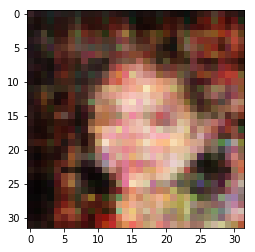

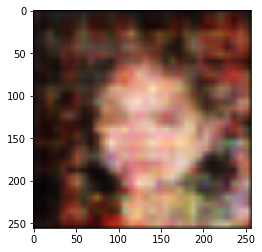

In [20]:
plt.figure()
plt.imshow(inverse_transform(samples[0]))
plt.figure()
plt.imshow(resize(inverse_transform(samples[0]),(256,256,3)))

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

In [19]:
z1 = np.random.uniform(-1, 1, [Z_DIM]).astype(np.float32)
z2 = np.random.uniform(-1, 1, [Z_DIM]).astype(np.float32)

batchz = []
for i in range(64):
    alpha = i/63.0
    batchz.append(z1*alpha + (1-alpha)*z2)

batchz = np.array(batchz).astype(np.float32)
print(batchz.shape)

with tf.Session() as sess:
    print("Reading checkpoints...")
    load(sess, 'checkpoint')
    print("Loaded checkpoints")
    samples = sess.run(G, feed_dict={z: batchz, is_training: False} )

(64, 50)
Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
Loaded checkpoints


Model 2 Output (Two sets of outputs shown)

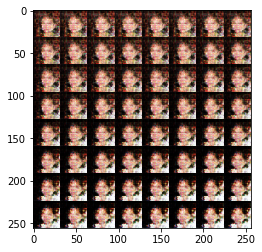

In [21]:
plt.imshow(inverse_transform(merge(samples, [8, 8])))

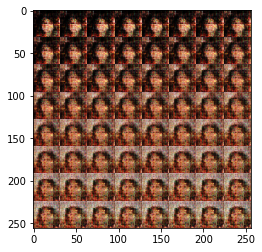

In [48]:
plt.imshow(inverse_transform(merge(samples, [8, 8])))

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

> Smile isn't easily discernible in the generated images, I approximate smile by 'visible outline of lips'

In [22]:
batchz = np.random.uniform(-1, 1, [64,Z_DIM]).astype(np.float32)

print(batchz.shape)

with tf.Session() as sess:
    print("Reading checkpoints...")
    load(sess, 'checkpoint')
    print("Loaded checkpoints")
    samples = sess.run(G, feed_dict={z: batchz, is_training: False} )

(64, 50)
Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model
Loaded checkpoints


In [25]:
resized_samples = np.array([resize(sample,(128,128,3)) for sample in samples])

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [38]:
smiling = [8,9,13,20,21]
not_smiling = [1,19,25,50,51]

In [41]:
smiling_z = np.array([batchz[i] for i in smiling])
smiling_samples = np.array([resized_samples[i] for i in smiling])
not_smiling_z = np.array([batchz[i] for i in not_smiling])
not_smiling_samples = np.array([resized_samples[i] for i in not_smiling])

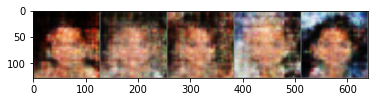

In [43]:
plt.imshow(inverse_transform(merge(smiling_samples, [1, 5])))

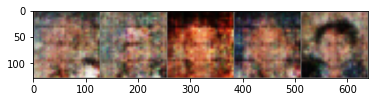

In [44]:
plt.imshow(inverse_transform(merge(not_smiling_samples, [1, 5])))

In [49]:
smile_vector = np.mean(smiling_z,axis=0) - np.mean(not_smiling_z,axis=0)
smile_vector.shape

(50,)

In [50]:
batchz = np.random.uniform(-1, 1, [64,Z_DIM]).astype(np.float32)
for i in range(32):
    batchz[2*i+1] = batchz[2*i]+smile_vector

print(batchz.shape)

with tf.Session() as sess:
    print("Reading checkpoints...")
    load(sess, 'checkpoint')
    print("Loaded checkpoints")
    smiling_samples = sess.run(G, feed_dict={z: batchz, is_training: False} )

(64, 50)
Reading checkpoints...
INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


INFO:tensorflow:Restoring parameters from checkpoint/dcgan.model


Loaded checkpoints


/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


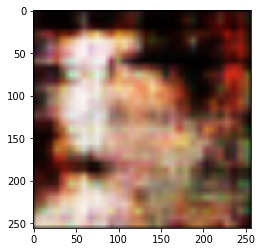

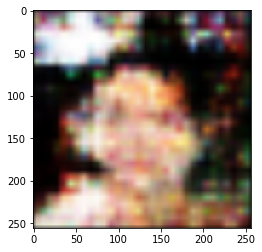

In [59]:
i=6
plt.figure()
plt.imshow(resize(inverse_transform(smiling_samples[2*i]),(256,256,3)))
plt.figure()
plt.imshow(resize(inverse_transform(smiling_samples[2*i+1]),(256,256,3)))

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


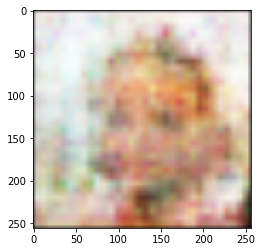

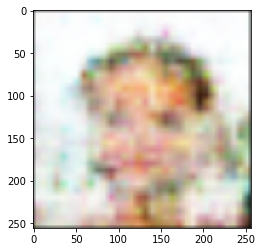

In [57]:
i=8
plt.figure()
plt.imshow(resize(inverse_transform(smiling_samples[2*i]),(256,256,3)))
plt.figure()
plt.imshow(resize(inverse_transform(smiling_samples[2*i+1]),(256,256,3)))

> The faces certainly seem to look better after adding the smile vector! The first example shown above looks more like a face, while the second certainly shows a grumpy woman break into a smiling woman.

If faces looks really cool, add bonus 1 point to your score.

> Definitely dont deserve any bonus marks haha. 

> Also. The 2 hours 'predicted' for every assignment in this course is the most laughable estimate of time taken ever. Hilarious, the assignments of this course were extremely time consuming and challenging. 